## Libaries

In [31]:
#import synapseclient as sc
import pandas as pd
from pandas import read_csv
import copy
import fastparquet
from datetime import datetime

import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
import imblearn

from tsfresh import extract_features
from tsfresh.feature_extraction import MinimalFCParameters
from tsfresh import extract_features, select_features
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from tsfresh.utilities.dataframe_functions import impute


from sklearn.metrics import roc_curve, auc, roc_auc_score
import seaborn as sns
from sklearn import model_selection


## Loading All The Created Dataframes 

In [2]:
#Synapse/Parkinsons Data
# sensortable1 = pd.read_parquet("./SynapseParkinsons/sensor_df.parquet")
# tasktable1 = pd.read_parquet("./SynapseParkinsons/tasktable1.parquet")
# demograph_query_park = pd.read_parquet("./SynapseParkinsons/demographics_query.parquet")

#Combined Data
# big_park_df = pd.read_parquet("./wlgs_dataframes/big_park_df.parquet")
# phone_data=pd.read_parquet("./wlgs_dataframes/phone_wlgs_df.parquet")

# Preprocessed Data (With Moving Average Filter and Gender Column)
#parkinsons_phone=pd.read_parquet("./preprocessed_dataframes/parkinsons_phone_g.parquet")
parkinsons_phone=pd.read_parquet("./preprocessed_dataframes/pd_elder.parquet") # dataset where each pd-patient is divided into multiple sections
healthy_elder = pd.read_parquet("./preprocessed_dataframes/healthy_elder_g.parquet")

# Concatenate Parkinsons and Healthy Dataframes 
big_df = pd.concat([parkinsons_phone, healthy_elder])

# Feature extraction Dataframe
#features = pd.read_parquet("./preprocessed_dataframes/features") # without gender column
features = pd.read_parquet("./preprocessed_dataframes/features1.parquet") #with gender column

# 1: Data Preprocessing 

Local download of all the Parkinsons Data (both the raw accelerometer data and meta data). Thereafter doing some filtering.

## 1. Parkinsons/Synapse Data

### 1.1. Login to Synapse to Import Data to PC

### 1.2. Sensor Table Part 1

#### 1.2.1. Download the smartwatch/smartphone sensor measurements

In [ ]:
sensor_measurements_query = syn.tableQuery("select * from syn20681931")
sensor_measurements_paths = syn.downloadTableColumns(sensor_measurements_query, "data_file_handle_id") # download data
sensor_measurements = sensor_measurements_query.asDataFrame() # pandas DataFrame
sensor_measurements['path'] = sensor_measurements.data_file_handle_id.astype(str).map(sensor_measurements_paths) #Column with file path

#File path on pc
sensor_measurements_query.filepath

In [ ]:
sensor_measurements

#### 1.2.2. Make a copy of the sensor table and filter out day 2 & 3

In [ ]:
sensortable1 = copy.copy(sensor_measurements)
sensor_df = sensortable1
sensor_df = sensor_df[(sensor_df["participant_day"] == 1) | (sensor_df["participant_day"] == 4)]
sensor_df.reset_index(drop=True, inplace=True) #reset index of the rows

In [ ]:
sensor_df

#### 1.2.3. Converting dataframe to parquet for quick loading

In [ ]:
#sensor_df.to_parquet("./SynapseParkinsons/sensor_df.parquet")

sensortable1 = pd.read_parquet("./SynapseParkinsons/sensor_df.parquet")

### 1.3. Task Scores Part I

#### 1.3.1. Download Task Scores Part I (smartwatch/smartphone)  

In [ ]:
tasks_query = syn.tableQuery("select * from syn20681937")

# File path on pc
tasks_query.filepath

In [ ]:
tasks_query

#### 1.3.2.  Filtering Task Table Part 1

In [ ]:
#Use Task table and sensor table in order to get to the txt-files
# start and stop timestamps = Task table
# timestamp = txt-files

tasktable1 = read_csv(tasks_query) #Convert to pandas dataframe
tasktable1 = copy.copy(tasktable1) #Make a copy of Task table

# Filter for the task "walking straight"
tasktable1_W = tasktable1[tasktable1["task_code"] == "wlkgs"] 
tasktable1_W["task_code"].unique() #checking if the values are only "wlkgs"

#Replace 2 with 4 in the visit-column so it matches with day 1 & 4
tasktable1_W.loc[tasktable1_W.visit == 2, 'visit'] = 4   # df.loc[<row selection>, <column selection>]

# Dropping columns, which we are not interested in
tasktable1_W = tasktable1_W.drop(['ROW_ID','phenotype', 'score', 'body_segment'], axis=1) #Dropping, because the columns are related to symptoms during the task and timestamps are the same for all bodysegments during a task

# Drop Duplicate Rows Keeping the First One
tasktable1_W = tasktable1_W.drop_duplicates()

# Rename "visit"-column
tasktable1_W.rename(columns={"visit": "participant_day"}, inplace = True)

# Sort subject column by ascending 
tasktable1_W = tasktable1_W.sort_values('subject_id')

# Reset index of the rows
tasktable1_W.reset_index(drop=True, inplace=True)  

tasktable1_W.head()        

In [ ]:
#Counting missing values
tasktable1_W.isna().sum()

#### 1.3.3. Converting dataframe to parquet for quick loading

In [ ]:
#tasktable1.to_parquet("./SynapseParkinsons/tasktable1.parquet")

tasktable1 = pd.read_parquet("./SynapseParkinsons/tasktable1.parquet")

### 1.4. Metadata of Patient Onboarding

#### 1.4.1. Download the demographic data

In [ ]:
demographics_query = syn.tableQuery("select * from syn20681894")  # this is stored as a csv at demographics_query.filepath
demographics_query.filepath

#### 1.4.2. Converting to parquet

In [ ]:
#demograph_query.to_parquet("./SynapseParkinsons/demographics_query.parquet")
demograph_query_park = pd.read_parquet("./SynapseParkinsons/demographics_query.parquet")

_____________________________________________________________________

# 2: Combining Synapse Dataframes to Make New  Ones

### 2.1. Making the Big Dataframe with Parkinsons data with Walking straight exercise on day 1 & 4 with All 3 Synapse sensors

In [ ]:
#NOTE:
#acc_df_test: acc. data (txt-file)
#sensor_df: sensor table w. day 1 & 4

acc_gait_df = []

for i in range(len(sensor_df)):          #for each row in the test dataframe do
    acc_df_test = read_csv(sensor_df['path'][i], sep='\t', low_memory=False) #acc. txt-files
    
    # adding subject_ID and participant_day to each acc. dataframe
    acc_df_test.insert(0, 'Subject_ID', sensor_df['subject_id'].iloc[i]) #Take subject id from the sensor table and insert as a column in txt-file in the first index
    acc_df_test.insert(1, 'Participant_day', sensor_df['participant_day'].iloc[i])    # iloc: Access group of rows and columns by integer position(s).
    
    # filter timestamps for the "wlkgs"-task in acc. data
    for i in range(len(tasktable1)):
        task_time_start = tasktable1.iloc[i]['timestamp_start']
        task_time_end = tasktable1.iloc[i]['timestamp_end']
        subject_id = tasktable1.iloc[i]['subject_id']
        participant_day = tasktable1.iloc[i]['participant_day']
        
        for i, row in sensor_df.iterrows():
            if row['subject_id'] == subject_id and row['participant_day'] == participant_day: #Making sure subject_id and participant_day are the same for the two tables (sensor & task), before accessing the corresponding acc.-file 
                acc_df_test_new = acc_df_test.loc[(acc_df_test['timestamp'] >= task_time_start) & (acc_df_test['timestamp'] <= task_time_end)] #Subset the acc.-file (txt-files)        
                #print(acc_df_test_new) #Cheking the output of the for-loop                
                acc_gait_df.append(acc_df_test_new)

acc_gait_df = pd.concat(acc_gait_df)
acc_gait_df.reset_index(drop=True, inplace=True) #reset index of the rows

acc_gait_df 

#### Converting dataframe to parquet for quick loading

In [3]:
#acc_gait_df.to_parquet("./wlgs_dataframes/big_park_df.parquet")

big_park_df = pd.read_parquet("./wlgs_dataframes/big_park_df.parquet")

In [ ]:
big_park_df

### 2.2. Making Phone Sensor Dataframe (from big_park_df)

In [ ]:
acc_phone_gait_df = []

for i in range(len(sensor_phone_df)):          #for each row in the test dataframe do
    acc_phone_df = read_csv(sensor_phone_df['path'][i], sep='\t', low_memory=False) #acc. txt-files
    
    # drop rows that contain the partial string "NaN" in the Magnitude and X-axes column
    acc_phone_df=acc_phone_df[~acc_phone_df.Phone_Magnitude.str.contains('|'.join('NaN'))]
    acc_phone_df=acc_phone_df[~acc_phone_df.Phone_X.str.contains('|'.join('NaN'))]
    
    # adding subject_ID and participant_day to each acc. dataframe
    acc_phone_df.insert(0, 'Subject_ID', sensor_phone_df['subject_id'].iloc[i]) #Take subject id from the sensor table and insert as a column in txt-file in the first index
    acc_phone_df.insert(1, 'Participant_day', sensor_phone_df['participant_day'].iloc[i])    # iloc: Access group of rows and columns by integer position(s).
    
    # filter timestamps for the "wlkgs"-task in acc. data
    for i in range(len(tasktable1_W)):
        task_time_start = tasktable1_W.iloc[i]['timestamp_start']
        task_time_end = tasktable1_W.iloc[i]['timestamp_end']
        subject_id = tasktable1_W.iloc[i]['subject_id']
        participant_day = tasktable1_W.iloc[i]['participant_day']
        
        for i, row in sensor_phone_df.iterrows():
            if row['subject_id'] == subject_id and row['participant_day'] == participant_day: #Making sure subject_id and participant_day are the same for the two tables (sensor & task), before accessing the corresponding acc.-file 
                acc_phone_gait_df_new = acc_phone_df.loc[(acc_phone_df['timestamp'] >= task_time_start) 
                                                         & (acc_phone_df['timestamp'] <= task_time_end)] #Subset the acc.-file (txt-files)        
                #print(acc_phone_gait_df_new) #Cheking the output of the for-loop                
                acc_phone_gait_df.append(acc_phone_gait_df_new)

acc_phone_gait_df = pd.concat(acc_phone_gait_df)
acc_phone_gait_df.reset_index(drop=True, inplace=True) #reset index of the rows
acc_phone_gait_df 

In [ ]:
# convert the columns "Phone_X", "Phone_Y", "Phone_Z" and "Phone_Magnitude" to float
acc_phone_gait_df[["Phone_X", "Phone_Y", "Phone_Z", "Phone_Magnitude"]] = acc_phone_gait_df[["Phone_X", "Phone_Y", "Phone_Z","Phone_Magnitude"]].apply(pd.to_numeric)

In [ ]:
#Counting NaN's
acc_phone_gait_df.isna().sum().sum()

#### Converting dataframe to parquet for quick loading

In [ ]:
#acc_phone_gait_df.to_parquet("./phone_wlgs_df.parquet")
phone_data=pd.read_parquet("./wlgs_dataframes/phone_wlgs_df.parquet")

___________________________________________________________________

# Step 3: More Data Processing 

Making the different dataframes to match each other & adding a column with moving average filter data

## 3.1. Making a Moving Average Function

In [ ]:
def movingAverage(df):
    """
    Input:
    The dataframe you want to mean filter. Must contain ID and VM
    
    Output:
    Returns a copy of the original dataset, with the mean average filtered vector magnitude added as a column
    """
    subjects = df["ID"].unique() # Getting list of all the patient ids
    placeholder_array = []

    for subject in subjects:
        cur_df = df[df["ID"] == subject].copy()

        # Filtering VM
        y = cur_df["VM"]
        y_mean = y.rolling(window=10, center=True, min_periods=5).mean()
        cur_df["movingAverage"] = y_mean

        # Adding it all the a placeholder array
        placeholder_array.append(cur_df)

    new_df = pd.concat(placeholder_array, axis=0, ignore_index=True)
    return new_df

### 3.2. Phone Data (Parkinsons)

In [ ]:
phone_data=pd.read_parquet("./wlgs_dataframes/phone_wlgs_df.parquet")

#### 3.2.1. Making time count (time_since_started column)

In [ ]:
# Getting list of all the patient ids
subjects_phone = phone_data["Subject_ID"].unique()

# Getting the participation day
days = phone_data["Participant_day"].unique() 

In [ ]:
placeholder_array = []

for subject in subjects_phone:
    for day in days:
        cur_df = phone_data[(phone_data["Subject_ID"] == subject) & (phone_data["Participant_day"] == day)].copy()
        
        # Reset index and multiply every sample with 0,02 sec
        cur_df.reset_index(inplace=True, drop=True)
        cur_df["time_since_started"] = cur_df.index * 0.02
        
        # Adding it all the a placeholder array
        placeholder_array.append(cur_df)

new_phone_df = pd.concat(placeholder_array, axis=0, ignore_index=True)

In [ ]:
new_phone_df

#### 3.2.2. Adding gender-column


In [ ]:
gender_park_df = demograph_query_park[["subject_id", "gender"]]
gender_park_df = copy.copy(gender_park_df)
gender_park_df['gender'].replace(['Male', 'Female'],[0, 1], inplace=True) #1:female, 0:male
gender_park_df.rename(columns={"subject_id": "ID"}, inplace=True)

In [ ]:
# Rename ID-column
new_phone_df = new_phone_df.rename(columns={"Subject_ID":"ID"})

#Merging Phone Dataframe with Gender-column
new_phone_df = new_phone_df.merge(gender_park_df, on="ID", how = 'inner')

#### 3.2.3. Cleaning and removing columns

In [ ]:
# Convert Subject_ID and Participant_day to string
new_phone_df = new_phone_df.astype({'ID':'string','Participant_day':'string'})
new_phone_df.dtypes

In [ ]:
# ID and Day into one column
new_phone_df["ID"] = new_phone_df["ID"] + "_" + new_phone_df["Participant_day"]
phone_data = new_phone_df.drop(columns=["Participant_day"])

# Phone data gets label 1
phone_data["label"] = 1

#### 3.2.4. Upsampling from 50 Hz to 100 Hz

In [ ]:
# # The timeseries contains around 0 timestamp dublicates, because the amount of ID's and date are the same.

#non_dup = phone_data[phone_data["ID"] == "10_BOS_1"]
#print(len(non_dup))
#non_dup = non_dup.drop_duplicates(subset=["date"])
#non_dup.set_index("date")
#print(len(non_dup))

In [ ]:
phone_data['date'] = pd.to_datetime(phone_data['timestamp'], unit="s")

In [ ]:
ill_patients_id = phone_data["ID"].unique()
placeholder_array = []

for patient in ill_patients_id:
    cur_patient = phone_data[phone_data["ID"] == patient].drop_duplicates(subset=["date"])
    cur_patient = cur_patient.drop(columns=["timestamp", "label", "ID"]).reset_index(drop=True)
    cur_patient = cur_patient.set_index("date")
    res_patient = cur_patient.resample('10ms').bfill(limit=1).interpolate()
    res_patient["ID"] = patient
    res_patient["label"] = 1
    res_patient.reset_index(inplace=True)
    placeholder_array.append(res_patient)
    
new_park_df = pd.concat(placeholder_array)

In [ ]:
# Rename columns and dropping "date"-dolumn
new_park_df = new_park_df.rename(columns={"Phone_X":"x", "Phone_Y":"y", "Phone_Z":"z", "Phone_Magnitude":"VM"}).drop(columns=["date"])

#### 3.2.5. Adding Moving Average Column

In [ ]:
new_park_df = movingAverage(new_park_df)

#### 3.2.6. Saving and Loadning Phone Dataset

In [ ]:
#new_park_df.to_parquet("./preprocessed_dataframes/parkinsons_phone_g.parquet")
parkinsons_phone=pd.read_parquet("./preprocessed_dataframes/parkinsons_phone.parquet")

### 3.3. Healthy Elder Data

#### 3.3.1. Converting the x-, y- and z-axes from g (gravity force) to m/s^2

In [ ]:
healthy_elder1 = pd.read_parquet('wlgs_dataframes/healthy_elder.parquet')

In [ ]:
healthy_elder = copy.copy(healthy_elder1)

healthy_elder['x'] = healthy_elder['x'] * 9.80665
healthy_elder['y'] = healthy_elder['y'] * 9.80665
healthy_elder['z'] = healthy_elder['z'] * 9.80665

#### 3.3.2. Recalculate VM and dropping the "filtered" and "meanAverage" column

In [ ]:
def calcVM(dataset, x, y, z):
    """
    Input:
    The full dataset that is used and the name of the three parameters that needs to be used to calculate 
    the vector magnitue, as strings. Usually the x-, y- and z-coordinate
    
    Output:
    Returns a copy of the original dataset, with the vector magnitude added as a column
    """
    
    name = "VM"
    walk_vm = dataset.copy()
    walk_vm[name] = np.sqrt(walk_vm[x]**2 + walk_vm[y]**2 + walk_vm[z]**2)
    #walk_vm = walk_vm.assign(VM = lambda walk_vm: (np.sqrt(walk_vm[x]**2 + walk_vm[y]**2 + walk_vm[z]**2)))
    #walk_vm.rename(columns={"VM": name})
    return walk_vm

In [ ]:
healthy_elder = calcVM(healthy_elder, 'x', 'y', 'z')

#Dropping columns which is not needed in our project
healthy_elder.drop(healthy_elder.columns[[7, 8]], axis=1, inplace=True)

#### 3.3.3. Adding Moving Average Column and Gender Column

In [ ]:
healthy_elder = movingAverage(healthy_elder)

In [ ]:
# Meta dataframes with gender-columns for the Healthy Paticipants

## Controls
ClinicalDemo_healthy_controls = pd.read_csv("./Healthy/ClinicalDemogData_COFL.csv", sep =";")

#Fallers
ClinicalDemo_healthy_fallers = pd.read_csv("./Healthy/ClinicalDemogData_FL.csv", sep =";")

#Make one df 
gender_healthy_df = pd.concat([ClinicalDemo_healthy_controls, ClinicalDemo_healthy_fallers])
gender_healthy_df = gender_healthy_df[["ID", "Gender"]] #1:female, 0:male
gender_healthy_df = copy.copy(gender_healthy_df)

#Column changes
gender_healthy_df.rename(columns={"Gender": "gender"}, inplace=True)
gender_healthy_df['ID'] = gender_healthy_df['ID'].str.lower()
gender_healthy_df['ID'] = gender_healthy_df['ID'].str.replace('-','')
gender_healthy_df['ID'] = gender_healthy_df['ID'].astype(str) + '_base'

In [ ]:
#Merging the Healthy Dataframe with gender column
healthy_elder = healthy_elder.merge(gender_healthy_df, on="ID", how = 'inner')
healthy_elder

#### 3.3.4. Saving the Healthy Dataframe

_________________________________________________________________________________________________

# Time Series Segmentation

In [4]:
data = big_df

# Define window size and overlap
window_size = 3000 # number of rows (samples) in each window (30 seconds of samples)
#window_size = 600 # number of rows (samples) in each window (6 seconds of samples)
overlap = int(window_size * 0.5) # number of rows overlapping between adjacent windows (here 50%)

# Empty list to store segmented data
segmented_data = []

# Loop over unique patients in the data
for patient_id in data['ID'].unique():
    # Subset data for the current patient
    patient_data = data[data['ID']==patient_id]
    
    # Calculate the number of windows for this patient
    n_windows = int(np.ceil((len(patient_data) - window_size) / overlap)) + 1
    
    # Loop over windows for this patient
    for i in range(n_windows):
        # Calculate the start and end indices for this window
        start_index = i * overlap
        end_index = start_index + window_size
        
        # Making sure the length of the last window is not less then the window size
        if end_index > len(patient_data):
            continue
        
        # Extract the window of data for this patient
        window = patient_data.iloc[start_index:end_index].copy()
        
        # Add a suffix to the patient ID to differentiate between segments
        window['ID'] = window['ID'] + '_' + str(i)
        
        # Append the windowed data to the list
        segmented_data.append(window)
        
# Concatenate the windowed data into a single dataframe
segmented_data = pd.concat(segmented_data, axis=0)
segmented_data.reset_index(drop=True, inplace=True) #reset index of the rows

In [5]:
Counter(segmented_data["ID"])

Counter({'10_BOS_1_0': 3000,
         '10_BOS_1_1': 3000,
         '10_BOS_1_2': 3000,
         '10_BOS_1_3': 3000,
         '10_BOS_1_4': 3000,
         '10_BOS_1_5': 3000,
         '10_BOS_1_6': 3000,
         '10_BOS_1_7': 3000,
         '10_BOS_1_8': 3000,
         '10_BOS_1_9': 3000,
         '10_BOS_1_10': 3000,
         '10_BOS_1_11': 3000,
         '10_BOS_1_12': 3000,
         '10_BOS_1_13': 3000,
         '10_BOS_1_14': 3000,
         '10_BOS_1_15': 3000,
         '10_BOS_1_16': 3000,
         '10_BOS_1_17': 3000,
         '10_BOS_1_18': 3000,
         '10_BOS_1_19': 3000,
         '10_BOS_1_20': 3000,
         '10_BOS_1_21': 3000,
         '10_BOS_1_22': 3000,
         '10_BOS_1_23': 3000,
         '10_BOS_1_24': 3000,
         '10_BOS_1_25': 3000,
         '10_BOS_1_26': 3000,
         '10_BOS_1_27': 3000,
         '10_BOS_1_28': 3000,
         '10_BOS_1_29': 3000,
         '10_BOS_1_30': 3000,
         '10_BOS_1_31': 3000,
         '10_BOS_4_0': 3000,
         '10_BOS_4_1'

In [6]:
segmented_data

,x,y,z,VM,gender,ID,label,time_since_started,movingAverage
0,9.062980,0.400130,-3.282520,9.647420,0.0,10_BOS_1_0,1.0,0.00,9.657546
1,9.062980,0.400130,-3.282520,9.647420,0.0,10_BOS_1_0,1.0,0.00,9.661497
2,9.077860,0.383210,-3.268090,9.655820,0.0,10_BOS_1_0,1.0,0.02,9.661540
3,9.077860,0.383210,-3.268090,9.655820,0.0,10_BOS_1_0,1.0,0.02,9.661573
4,9.089840,0.376730,-3.310510,9.681250,0.0,10_BOS_1_0,1.0,0.04,9.662513
...,...,...,...,...,...,...,...,...,...
5402995,7.160074,-0.903492,-0.099467,7.217537,1.0,co020_base_1,0.0,44.95,7.443448
5402996,7.187882,-1.044662,-0.127842,7.264524,1.0,co020_base_1,0.0,44.96,7.427220
5402997,7.243632,-1.101131,0.014136,7.326861,1.0,co020_base_1,0.0,44.97,7.402621
5402998,7.354998,-1.072896,0.127842,7.433939,1.0,co020_base_1,0.0,44.98,7.374489


### Visualizing the segments for a patient with pakinsons and a person without

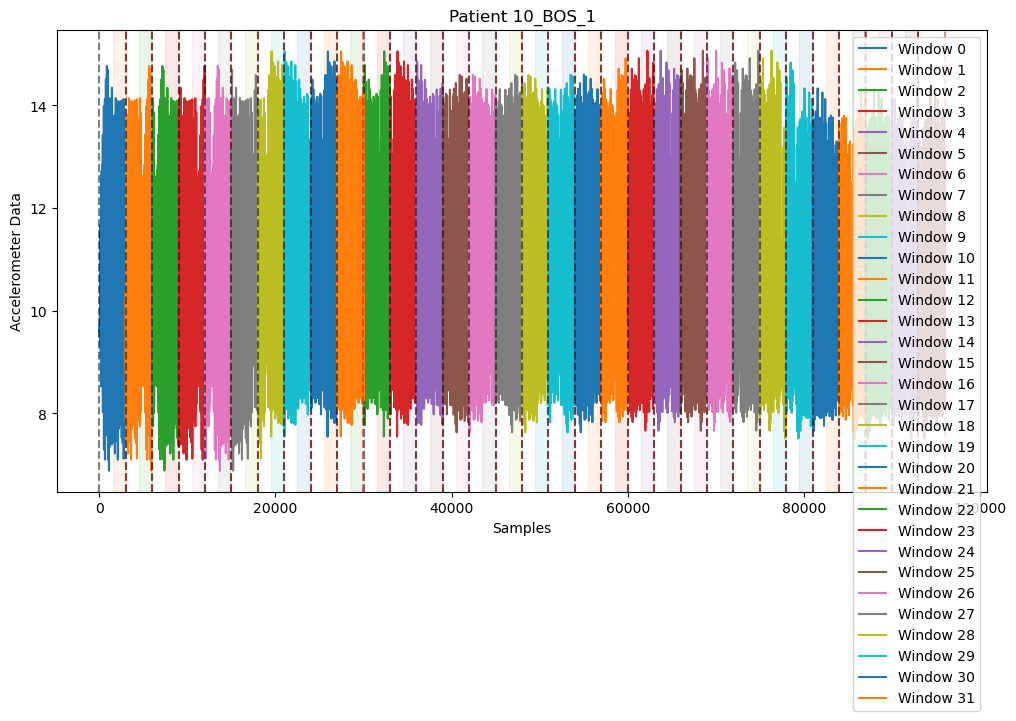

In [7]:
# Parkinsons patient
patient_id = '10_BOS_1'
patient_data = segmented_data[segmented_data['ID'].str.startswith(str(patient_id))]

fig, ax = plt.subplots(figsize=(12,6))

# Plot accelerometer data for each window
for i, (idx, window) in enumerate(patient_data.groupby('ID')):
    x = window.index
    y = window['movingAverage']
    #y = window[['x','y','z']]
    ax.plot(x, y, label=f'Window {i}')
    
    # Show start and end of window
    start_idx = x[0]
    end_idx = x[0] + window_size - 1
    ax.axvline(start_idx, color='k', linestyle='--', alpha=0.5)
    ax.axvline(end_idx, color='r', linestyle='--', alpha=0.5)
    
    if i > 0:
        # Show overlap with previous window
        overlap_start = x[0] - overlap
        overlap_end = x[0]
        ax.axvspan(overlap_start, overlap_end, color=f'C{i}', alpha=0.1)
        
    # Update start index for next window
    start_idx += overlap
        
ax.set_xlabel('Samples')
ax.set_ylabel('Accelerometer Data')
ax.set_title(f'Patient {patient_id}')
ax.legend()
plt.show()

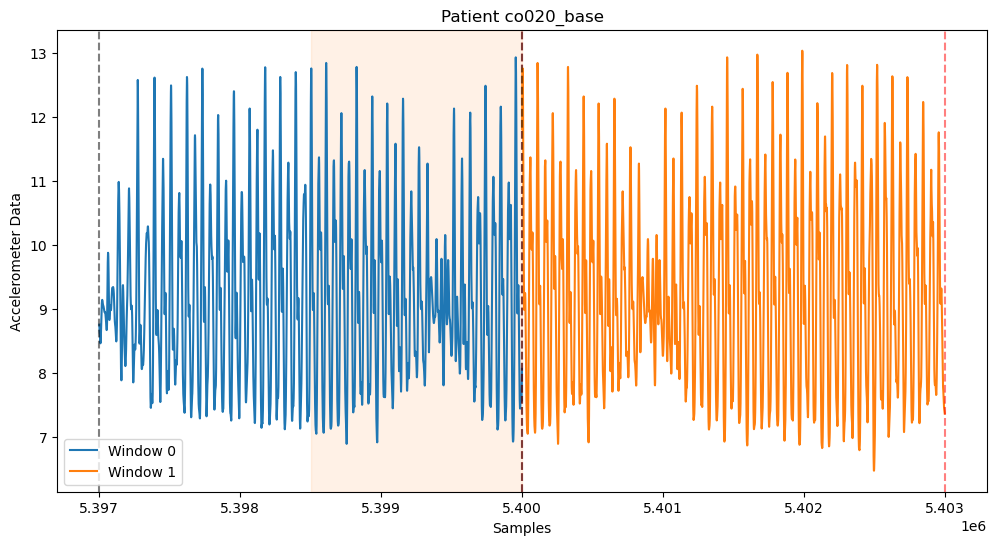

In [8]:
# Healthy patient
patient_id = 'co020_base'
patient_data = segmented_data[segmented_data['ID'].str.startswith(str(patient_id))]

fig, ax = plt.subplots(figsize=(12,6))

# Plot accelerometer data for each window
for i, (idx, window) in enumerate(patient_data.groupby('ID')):
    x = window.index
    y = window['movingAverage']
    #y = window[['x','y','z']]
    ax.plot(x, y, label=f'Window {i}')
    
    # Show start and end of window
    start_idx = x[0]
    end_idx = x[0] + window_size - 1
    ax.axvline(start_idx, color='k', linestyle='--', alpha=0.5)
    ax.axvline(end_idx, color='r', linestyle='--', alpha=0.5)
    
    if i > 0:
        # Show overlap with previous window
        overlap_start = x[0] - overlap
        overlap_end = x[0]
        ax.axvspan(overlap_start, overlap_end, color=f'C{i}', alpha=0.1)
        
    # Update start index for next window
    start_idx += overlap
        
ax.set_xlabel('Samples')
ax.set_ylabel('Accelerometer Data')
ax.set_title(f'Patient {patient_id}')
ax.legend()
plt.show()

In [9]:
big_df = segmented_data

# 4: Data Visualization and Scaling

### 4.1. Making one big dataframe containing healthy and phone data

In [10]:
big_df

,x,y,z,VM,gender,ID,label,time_since_started,movingAverage
0,9.062980,0.400130,-3.282520,9.647420,0.0,10_BOS_1_0,1.0,0.00,9.657546
1,9.062980,0.400130,-3.282520,9.647420,0.0,10_BOS_1_0,1.0,0.00,9.661497
2,9.077860,0.383210,-3.268090,9.655820,0.0,10_BOS_1_0,1.0,0.02,9.661540
3,9.077860,0.383210,-3.268090,9.655820,0.0,10_BOS_1_0,1.0,0.02,9.661573
4,9.089840,0.376730,-3.310510,9.681250,0.0,10_BOS_1_0,1.0,0.04,9.662513
...,...,...,...,...,...,...,...,...,...
5402995,7.160074,-0.903492,-0.099467,7.217537,1.0,co020_base_1,0.0,44.95,7.443448
5402996,7.187882,-1.044662,-0.127842,7.264524,1.0,co020_base_1,0.0,44.96,7.427220
5402997,7.243632,-1.101131,0.014136,7.326861,1.0,co020_base_1,0.0,44.97,7.402621
5402998,7.354998,-1.072896,0.127842,7.433939,1.0,co020_base_1,0.0,44.98,7.374489


### 4.2. Looking at the Class Distribution

In [11]:
# Distribution of target varible (1 = parkinsons, 0 = healthy)
big_df['label'].value_counts()

1.0    4995000
0.0     408000
Name: label, dtype: int64

In [12]:
# Plot size settings
plt.rcParams["figure.figsize"] = (5,10)
font = {'weight' : 'normal',
        'size'   : 12}

<AxesSubplot: ylabel='label'>

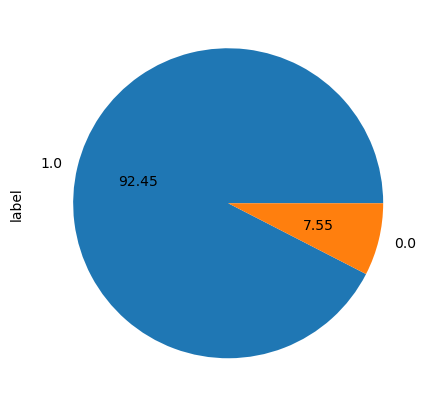

In [13]:
#Pie plot with pandas
X = big_df.drop(['label'], axis=1)
y = big_df['label']

y.value_counts().plot.pie(autopct='%.2f')

### 4.3. ID-extracting

In [14]:
subject_ids = []
ill_ids = []
healthy_ids = []


for subject in big_df["ID"].unique():
    subject_ids.append(subject)
    if "BOS" in subject:
        ill_ids.append(subject)
    elif "NYC" in subject:
        ill_ids.append(subject)
    else:
        healthy_ids.append(subject)

### 4.4. Visualize Random VM & MovingAverage Sample

In [15]:
# Plot size settings
plt.rcParams["figure.figsize"] = (18,10)
font = {'weight' : 'normal',
        'size'   : 12}

mpl.rc('font', **font)

Text(0.5, 1.0, 'Random VM and Moving Average sample illustrated')

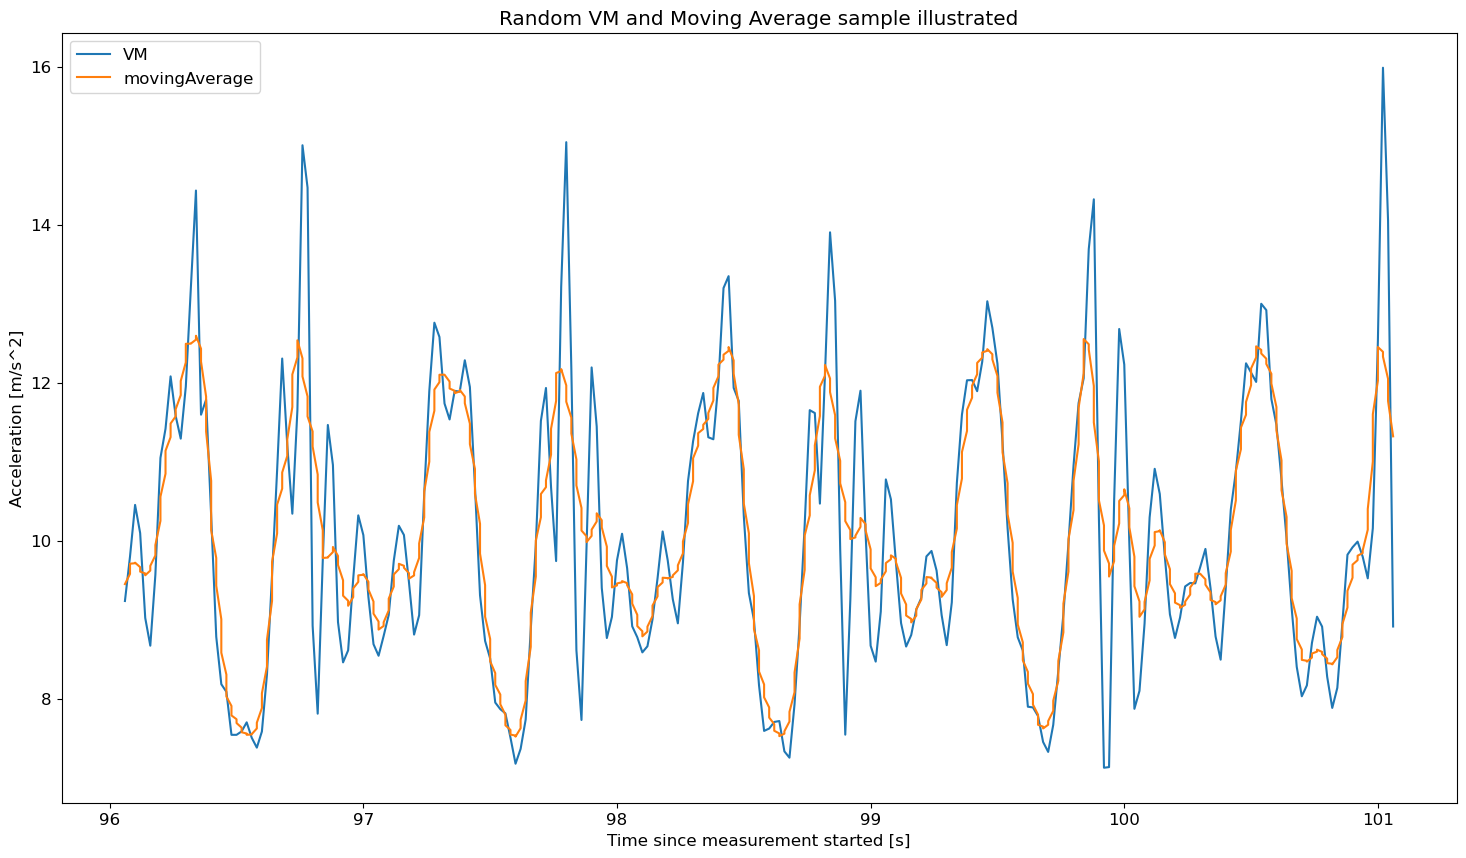

In [16]:
random_subject = random.choice(subject_ids)
random_sample = big_df[big_df["ID"] == random_subject].iloc[:500]

x = random_sample["time_since_started"]
y1 = random_sample["VM"]
y2 = random_sample["movingAverage"]

plt.plot(x, y1, label="VM")
plt.plot(x, y2, label="movingAverage")

plt.xlabel("Time since measurement started [s]")
plt.ylabel("Acceleration [m/s^2]")
plt.legend()
plt.title("Random VM and Moving Average sample illustrated")

### 4.5. Comparing random ill and healthy

#### 4.5.1. MovingAverage VM

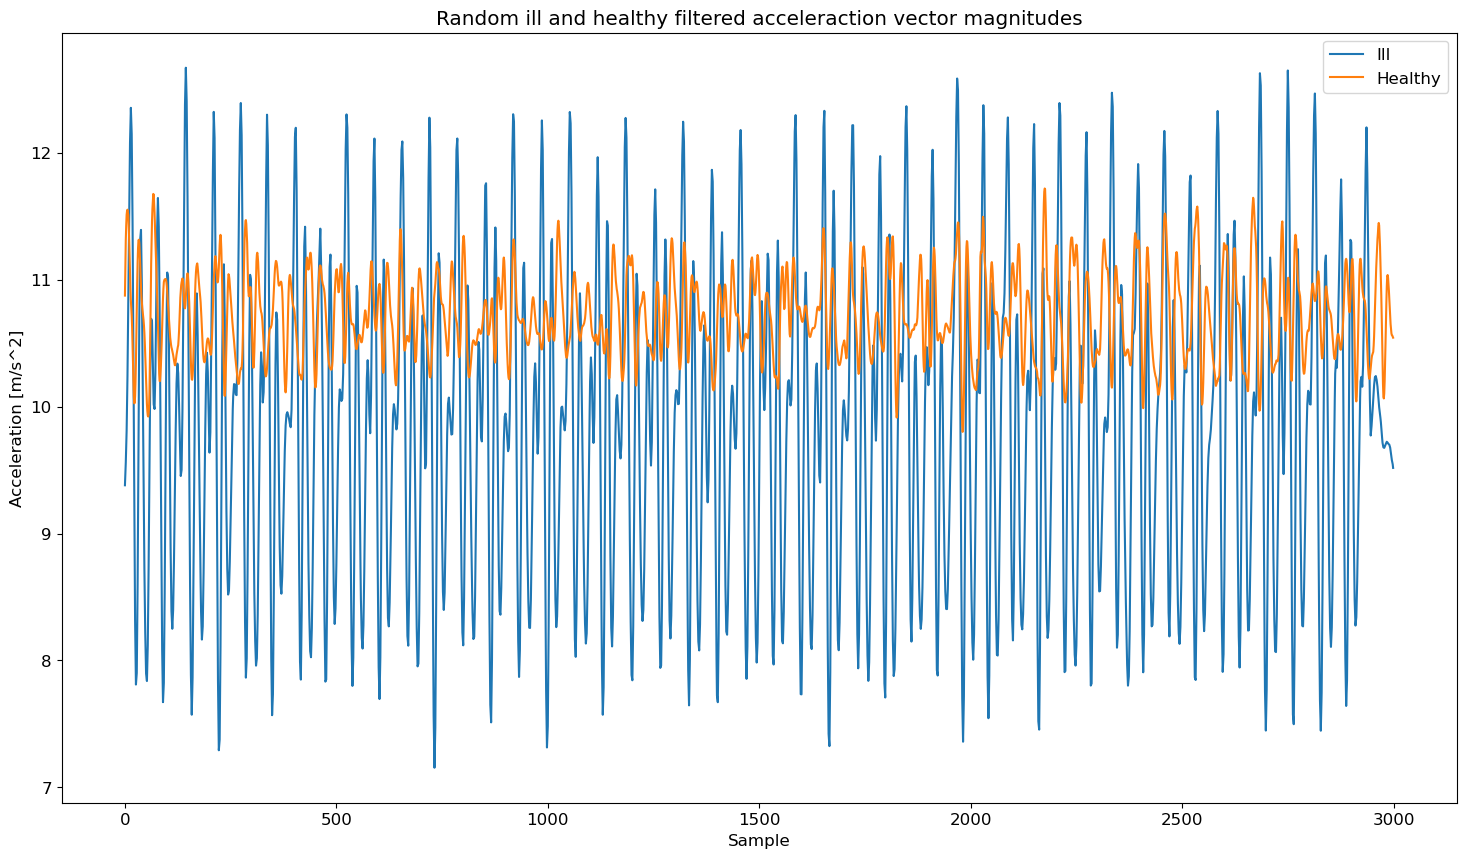

In [17]:
random_ill = random.choice(ill_ids)
random_healthy = random.choice(healthy_ids)
num_of_samples = 3000

y_ill = big_df[big_df["ID"] == random_ill]["movingAverage"].reset_index(drop=True).loc[:num_of_samples]
y_healthy = big_df[big_df["ID"] == random_healthy]["movingAverage"].reset_index(drop=True).loc[:num_of_samples]

plt.plot(y_ill, label="Ill")
plt.plot(y_healthy, label="Healthy")

plt.xlabel("Sample")
plt.ylabel("Acceleration [m/s^2]")
plt.title("Random ill and healthy filtered acceleraction vector magnitudes")
plt.legend()

#### 4.5.2. Comparing x-, y- and z-axes for ill and healthy

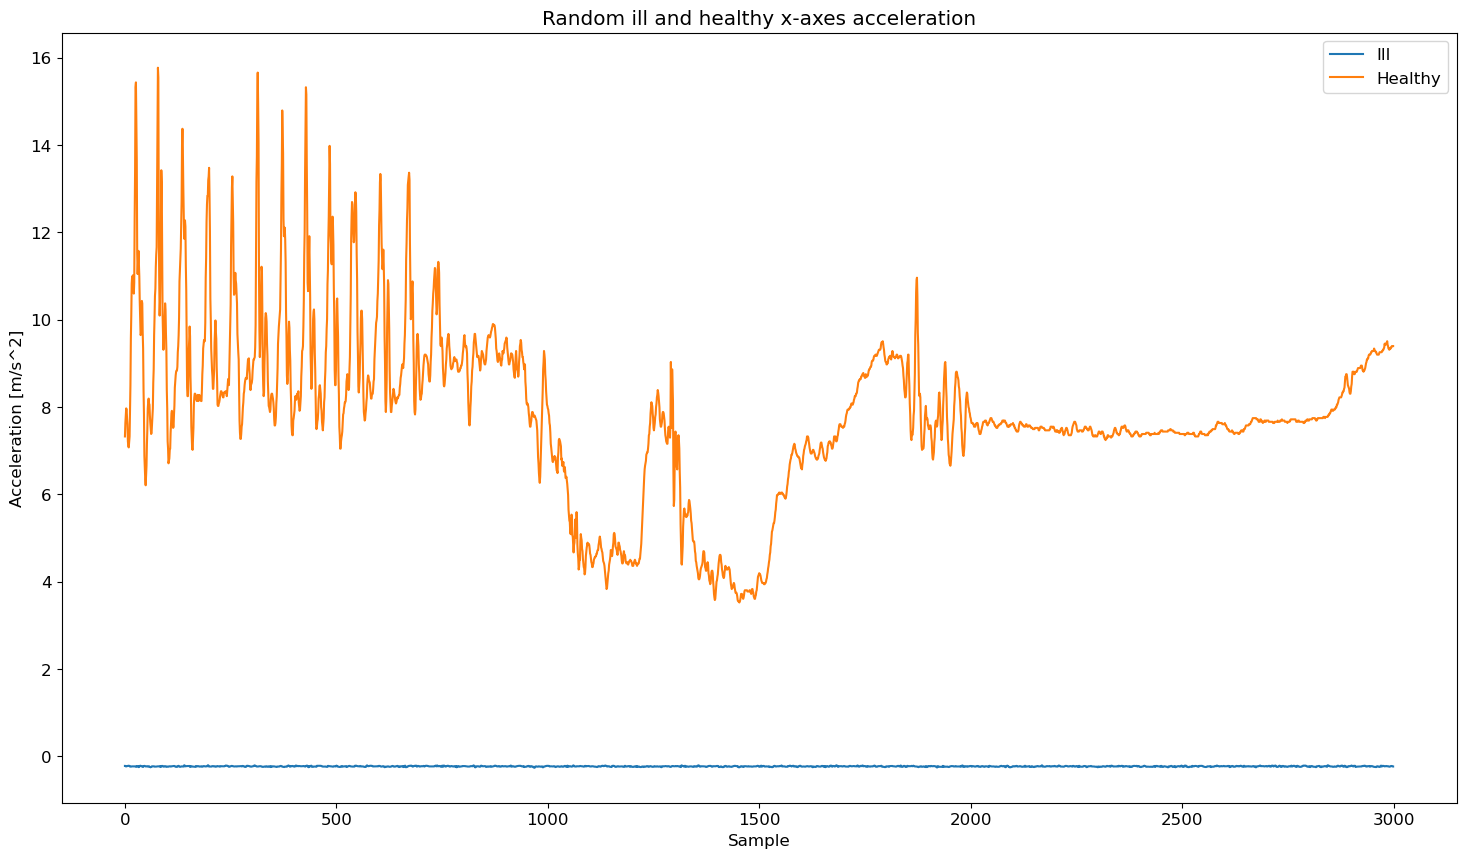

In [18]:
random_ill = random.choice(ill_ids)
random_healthy = random.choice(healthy_ids)
num_of_samples = 3000

# Looking at the x-axes for ill and healthy
y_ill = big_df[big_df["ID"] == random_ill]["x"].reset_index(drop=True).loc[:num_of_samples]
y_healthy = big_df[big_df["ID"] == random_healthy]["x"].reset_index(drop=True).loc[:num_of_samples]

# Looking at the y-axes for ill and healthy
#y_ill = big_df[big_df["ID"] == random_ill]["y"].reset_index(drop=True).loc[:num_of_samples]
#y_healthy = big_df[big_df["ID"] == random_healthy]["y"].reset_index(drop=True).loc[:num_of_samples]

# Looking at the z-axes for ill and healthy
#y_ill = big_df[big_df["ID"] == random_ill]["z"].reset_index(drop=True).loc[:num_of_samples]
#y_healthy = big_df[big_df["ID"] == random_healthy]["z"].reset_index(drop=True).loc[:num_of_samples]

plt.plot(y_ill, label="Ill")
plt.plot(y_healthy, label="Healthy")

plt.xlabel("Sample")
plt.ylabel("Acceleration [m/s^2]")
plt.title("Random ill and healthy x-axes acceleration")
plt.legend()

### 4.6. Scaling 

In [19]:
# Load time-series data into a pandas DataFrame
df = big_df
dfs_by_patient_id=[]

# Define the columns to scale and normalize
columns_to_normalize = ['x', 'y', 'z', 'VM', 'movingAverage']

# Normalize and scale each participant's data
scaler = StandardScaler()

for subject in subject_ids:
    # Extract the subject's data based on their ID
    subject_data = df.loc[df['ID'] == subject].copy()
    
    # Normalize and scale the selected columns
    subject_data[columns_to_normalize] = scaler.fit_transform(subject_data[columns_to_normalize])
    
    # Append the subject's data to the list of dataframes
    dfs_by_patient_id.append(subject_data)
    
# Concatenate the data back together
scaler_df = pd.concat(dfs_by_patient_id)

In [20]:
scaler_df

,x,y,z,VM,gender,ID,label,time_since_started,movingAverage
0,0.085986,0.106057,0.281437,-0.094241,0.0,10_BOS_1_0,1.0,0.00,-0.147903
1,0.085986,0.106057,0.281437,-0.094241,0.0,10_BOS_1_0,1.0,0.00,-0.145226
2,0.093081,0.094055,0.289141,-0.090768,0.0,10_BOS_1_0,1.0,0.02,-0.145197
3,0.093081,0.094055,0.289141,-0.090768,0.0,10_BOS_1_0,1.0,0.02,-0.145175
4,0.098793,0.089458,0.266495,-0.080254,0.0,10_BOS_1_0,1.0,0.04,-0.144537
...,...,...,...,...,...,...,...,...,...
5402995,-1.131909,-0.534082,0.612063,-1.161505,1.0,co020_base_1,0.0,44.95,-1.189888
5402996,-1.115224,-0.678807,0.586316,-1.133961,1.0,co020_base_1,0.0,44.96,-1.200888
5402997,-1.081773,-0.736697,0.715145,-1.097417,1.0,co020_base_1,0.0,44.97,-1.217563
5402998,-1.014952,-0.707752,0.818321,-1.034646,1.0,co020_base_1,0.0,44.98,-1.236632


In [21]:
big_df = scaler_df

_________________________________________________________________________________________________

# 5: Feature Extraction & Selection

### 5.1. Extract Features

In [ ]:
# Extracting features using tsfresh library
# Doesn't work without default_fc_parameters set, Mikkel only tried minimal setting
# Using all the columns
features = []

for subject in subject_ids:
    timeseries = big_df[big_df["ID"] == subject]
    extracted_features = extract_features(timeseries, column_id="ID", column_sort="time_since_started", n_jobs=0, default_fc_parameters=MinimalFCParameters())
    features.append(extracted_features)
    
features = pd.concat(features)

In [23]:
features 

,x__sum_values,x__median,x__mean,x__length,x__standard_deviation,x__variance,x__root_mean_square,x__maximum,x__minimum,y__sum_values,...,label__minimum,movingAverage__sum_values,movingAverage__median,movingAverage__mean,movingAverage__length,movingAverage__standard_deviation,movingAverage__variance,movingAverage__root_mean_square,movingAverage__maximum,movingAverage__minimum
10_BOS_1_0,4.227729e-13,0.005507,1.409243e-16,3000.0,1.0,1.0,1.0,4.991043,-2.858618,5.684342e-14,...,1.0,2.863487e-12,-0.189408,9.544957e-16,3000.0,1.0,1.0,1.0,3.315968,-2.027590
10_BOS_1_1,-1.378453e-12,-0.003887,-4.594843e-16,3000.0,1.0,1.0,1.0,5.063589,-2.897232,-4.973799e-14,...,1.0,-1.477929e-12,-0.192560,-4.926430e-16,3000.0,1.0,1.0,1.0,3.355306,-2.048608
10_BOS_1_2,-3.375078e-13,0.008108,-1.125026e-16,3000.0,1.0,1.0,1.0,5.054592,-2.886045,0.000000e+00,...,1.0,3.126388e-13,-0.189055,1.042129e-16,3000.0,1.0,1.0,1.0,3.362348,-2.048609
10_BOS_1_3,6.341594e-13,-0.003055,2.113865e-16,3000.0,1.0,1.0,1.0,5.039284,-2.669072,3.552714e-14,...,1.0,2.642331e-13,-0.192008,8.807769e-17,3000.0,1.0,1.0,1.0,3.382275,-1.909047
10_BOS_1_4,6.536993e-13,-0.000325,2.178998e-16,3000.0,1.0,1.0,1.0,5.048170,-2.881792,1.136868e-13,...,1.0,9.112711e-13,-0.195524,3.037570e-16,3000.0,1.0,1.0,1.0,3.345925,-2.040425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
co023_base_0,-9.565682e-13,-0.085734,-3.188561e-16,3000.0,1.0,1.0,1.0,3.954829,-1.900601,-1.136868e-13,...,0.0,-1.046274e-12,0.061147,-3.487581e-16,3000.0,1.0,1.0,1.0,2.298241,-2.059196
fl035_base_0,-3.410605e-13,-0.266687,-1.136868e-16,3000.0,1.0,1.0,1.0,4.840656,-1.576256,1.989520e-13,...,0.0,1.669775e-13,-0.230261,5.565918e-17,3000.0,1.0,1.0,1.0,3.099525,-1.539506
fl035_base_1,-1.005418e-12,-0.281581,-3.351393e-16,3000.0,1.0,1.0,1.0,5.556620,-1.446211,3.552714e-15,...,0.0,1.444178e-12,-0.235241,4.813927e-16,3000.0,1.0,1.0,1.0,3.140416,-1.622154
co020_base_0,1.666223e-12,-0.162194,5.554076e-16,3000.0,1.0,1.0,1.0,3.572220,-1.728814,-1.136868e-13,...,0.0,1.511680e-12,-0.122581,5.038932e-16,3000.0,1.0,1.0,1.0,2.798147,-1.702392


In [24]:
#list(features)

#Convert to parquet and save
features.to_parquet("preprocessed_dataframes/features1.parquet")

### 5.2. Comparing Features - Pakinsons & Healthy

Text(0.5, 1.0, 'Random parkinsons and healthy subject features')

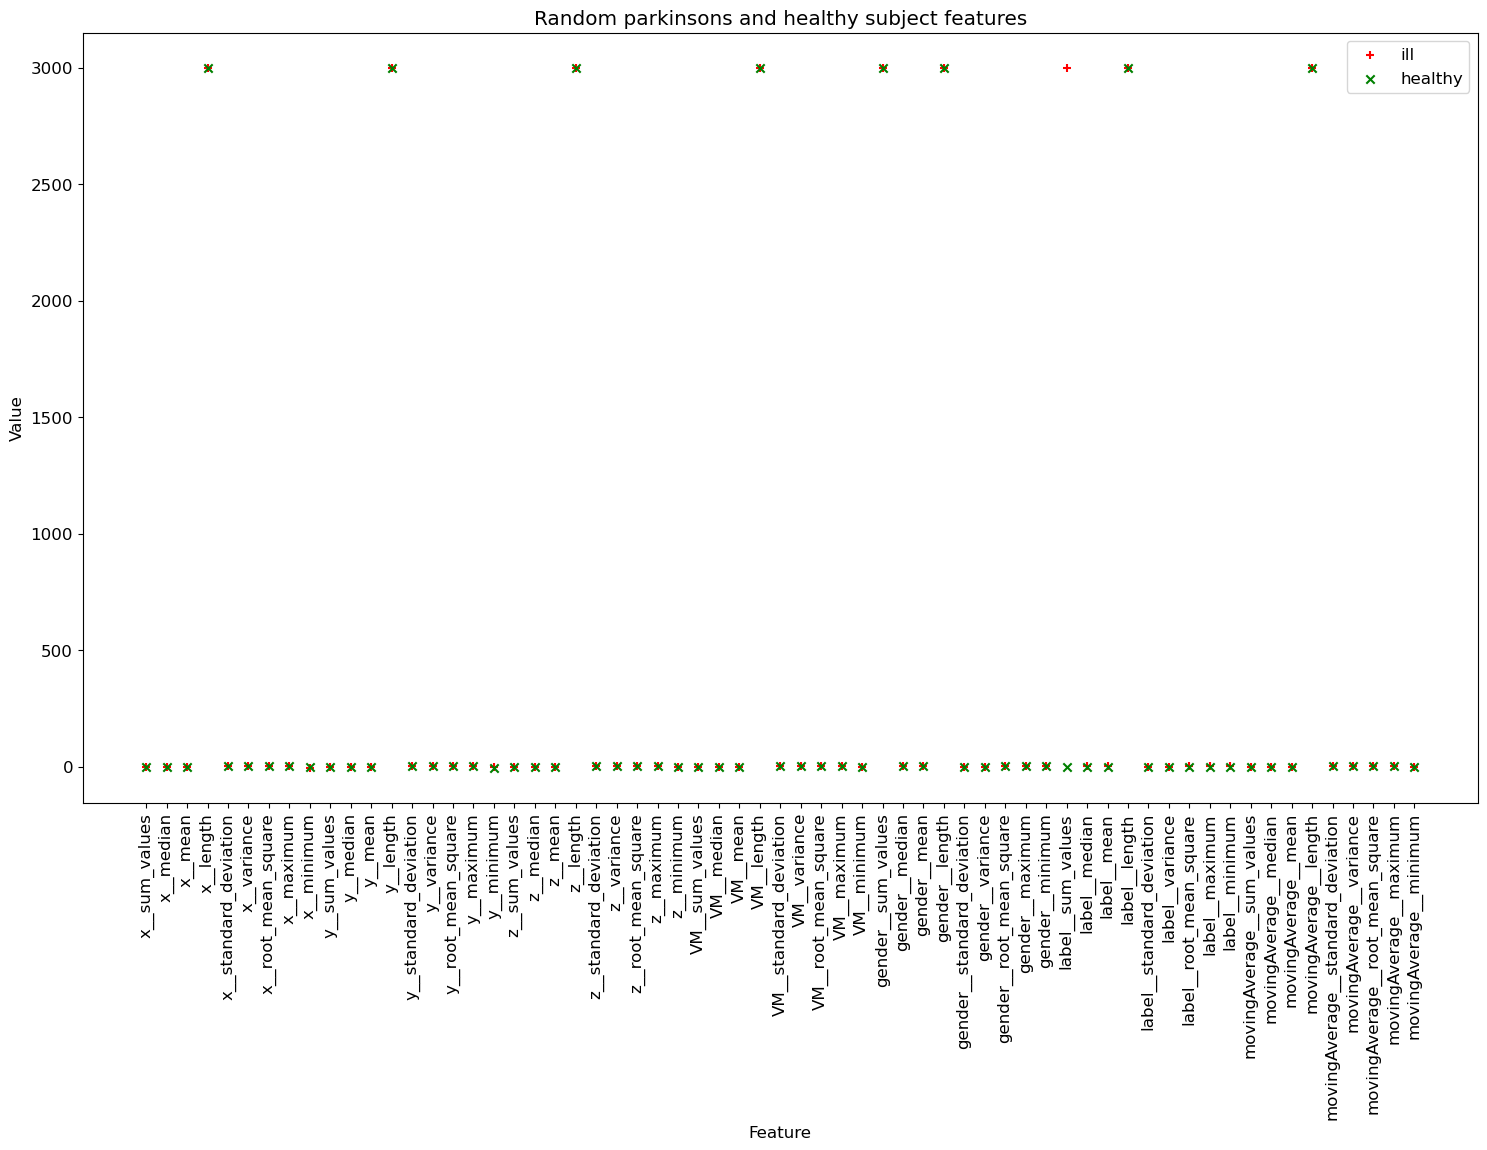

In [25]:
random_ill = random.choice(ill_ids)
random_healthy = random.choice(healthy_ids)

ill_feats = features.loc[random_ill]
healthy_feats = features.loc[random_healthy]

plt.xticks(rotation=90)
plt.xlabel("Feature")
plt.ylabel("Value")
plt.scatter(ill_feats.index, ill_feats, color="red", marker="+", label="ill")
plt.scatter(healthy_feats.index, healthy_feats, color="green", marker="x", label="healthy")
plt.legend()
plt.title("Random parkinsons and healthy subject features")

### 5.3. Feature Selection

#### 5.3.1. Asigning X (features) and y (target variable)

In [26]:
X = features.drop(columns=['label__sum_values',
                           'label__median',
                           'label__mean',
                           'label__length',
                           'label__standard_deviation',
                           'label__variance',
                           'label__root_mean_square',
                           'label__maximum',
                           'label__minimum',
                           'gender__sum_values',
                           'gender__median',
                           'gender__mean',
                           'gender__length',
                           'gender__standard_deviation',
                           'gender__variance',
                           'gender__root_mean_square',
                           'gender__maximum',
                           'gender__minimum',
                          ])


y = features['label__mean']

#### 5.3.2. Feature importance from coefficients

In [33]:
# Plot size settings
plt.rcParams["figure.figsize"] = (20,10)
font = {'weight' : 'normal',
        'size'   : 16}

ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X, y)
importance = np.abs(ridge.coef_)
feature_names = np.array(list(X))
plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.xticks(rotation=90)
plt.show()

#### 5.3.2.1 Another way of selecting features

In [32]:
# we impute = remove all NaN features automatically
impute(features)

#select relevant features
selected_features = select_features(X, y, ml_task='classification')


In [34]:
list(selected_features)

['x__median',
 'x__maximum',
 'x__minimum',
 'movingAverage__minimum',
 'VM__median',
 'y__maximum',
 'movingAverage__median',
 'VM__minimum',
 'z__maximum',
 'z__median',
 'VM__maximum',
 'y__minimum',
 'z__minimum']

In [35]:
#checking Nan's
features.isna().sum().sum() 

0

#### 5.3.3. Comparing feature values for Parkinsons and Healthy Patients

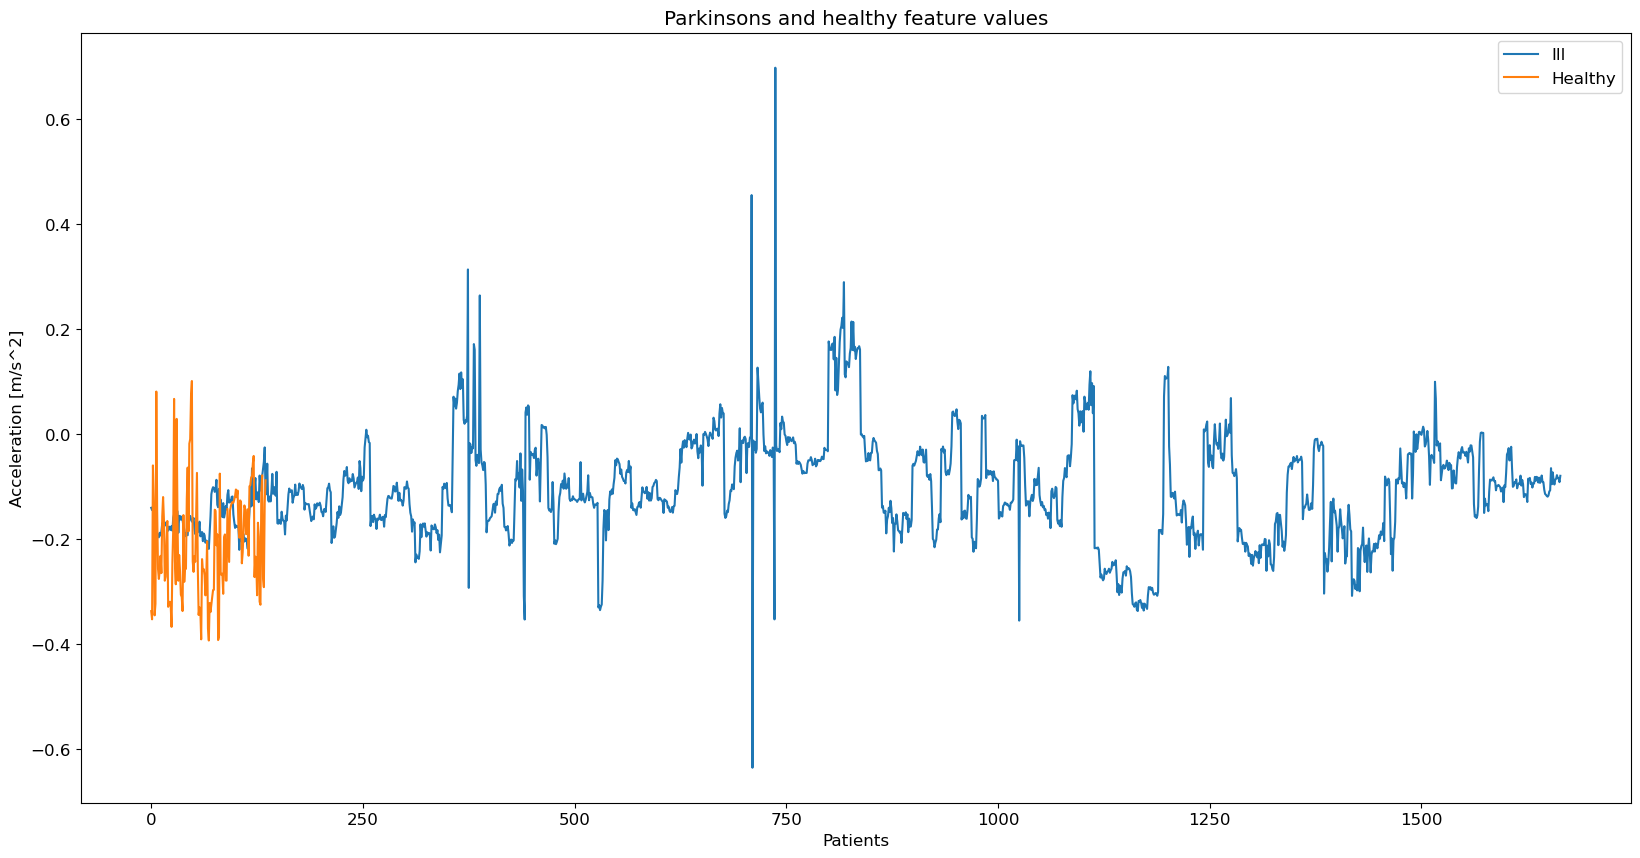

In [36]:
y_ill = features[features["label__mean"] == 1]["VM__median"].reset_index(drop=True)
y_healthy = features[features["label__mean"] == 0]["VM__median"].reset_index(drop=True)
plt.plot(y_ill, label="Ill")
plt.plot(y_healthy, label="Healthy")

plt.xlabel("Patients")
plt.ylabel("Acceleration [m/s^2]")
plt.title("Parkinsons and healthy feature values")
plt.legend()

#### 5.3.4. Final feature selection - Preparing the new X (selected features) and y (target)

In [37]:
list(features)

['x__sum_values',
 'x__median',
 'x__mean',
 'x__length',
 'x__standard_deviation',
 'x__variance',
 'x__root_mean_square',
 'x__maximum',
 'x__minimum',
 'y__sum_values',
 'y__median',
 'y__mean',
 'y__length',
 'y__standard_deviation',
 'y__variance',
 'y__root_mean_square',
 'y__maximum',
 'y__minimum',
 'z__sum_values',
 'z__median',
 'z__mean',
 'z__length',
 'z__standard_deviation',
 'z__variance',
 'z__root_mean_square',
 'z__maximum',
 'z__minimum',
 'VM__sum_values',
 'VM__median',
 'VM__mean',
 'VM__length',
 'VM__standard_deviation',
 'VM__variance',
 'VM__root_mean_square',
 'VM__maximum',
 'VM__minimum',
 'gender__sum_values',
 'gender__median',
 'gender__mean',
 'gender__length',
 'gender__standard_deviation',
 'gender__variance',
 'gender__root_mean_square',
 'gender__maximum',
 'gender__minimum',
 'label__sum_values',
 'label__median',
 'label__mean',
 'label__length',
 'label__standard_deviation',
 'label__variance',
 'label__root_mean_square',
 'label__maximum',
 'lab

In [38]:
X = features[['x__median',
              'x__maximum',
              'x__minimum',
              'y__median',
              'y__maximum',
              'y__minimum',
              'z__median',
              'z__maximum',
              'z__minimum',
              'VM__median',
              'VM__maximum',
              'VM__minimum',
              'movingAverage__median',
              'movingAverage__maximum',
              'movingAverage__minimum']]

y = features['label__mean']

In [39]:
X = selected_features

y = features['label__mean']

_______________________________________________________________________

# 6: Resampling 

### 6.1. Splitting the data into training and test set before resampling

We will only resample on the traning set. The test set will be used later in the final models.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### 6.2. Combination of upsampling and downsampling

Using SMOTE to oversample the minority class first and afterwards using RandomUnderSampler to undersample the majority class.

from imblearn.pipeline import make_pipeline

#Define the resampling pipeline
resampling_pipeline = make_pipeline(
    SMOTE(sampling_strategy='minority', random_state = 42),
    RandomUnderSampler(sampling_strategy='majority', random_state = 42)
)

#Fit and transform the data using the pipeline
X_train_resampled, y_train_resampled = resampling_pipeline.fit_resample(X_train, y_train)

#Print the shape of the original and resampled data
print(f"Original dataset shape: {X.shape}, {y.shape}")
print(f"Resampled dataset shape: {X_train_resampled.shape}, {y_train_resampled.shape}")

In [41]:
#Resample (mix) the data using SMOTE and RandomUnderSampler
smote = SMOTE(random_state=42)
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_resampled, y_train_resampled)

#Print the shape of the original and resampled data
print(f"Original dataset shape: {X.shape}, {y.shape}")
print(f"Resampled dataset shape: {X_train_resampled.shape}, {y_train_resampled.shape}")

Original dataset shape: (1801, 13), (1801,)
Resampled dataset shape: (2236, 13), (2236,)


### 6.3. Visual of the new class distribution after resampling

In [99]:
# Plot size settings
plt.rcParams['font.size'] = 12.0
plt.rcParams["figure.figsize"] = (5,8)
font = {'weight' : 'normal',
        'size'   : 12}

Counter({1.0: 1665, 0.0: 136})

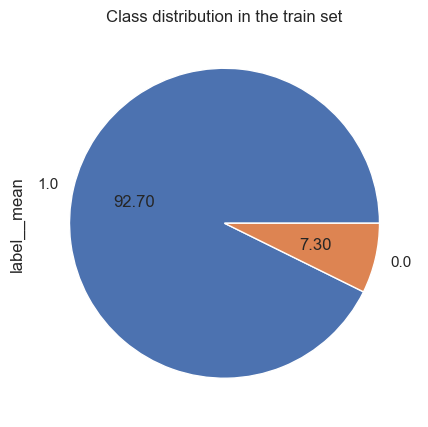

In [105]:
#Plot the distribution of patients with and without parkinsons
ax = y_train.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Class distribution in the train set")
Counter(y)

Counter({0.0: 1118, 1.0: 1118})

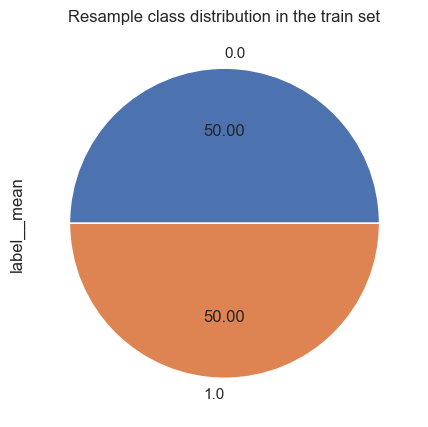

In [103]:
#Plot the distribution of patients with and without parkinsons
ax = y_train_resampled.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Resample class distribution in the train set")
Counter(y_train_resampled) 

_______________________________________________________________________


# 7: Hyperparameter tuning ML-models with GridSearchCV

Using the resample training data.

### 7.0. Function which shows the classification reports and confusion matrix for each tuned model

In [232]:
#model build for different binary classification and show confusion matrix
def build_model(model_name, X_train, y_train, X_test, y_test):
    if model_name =='KNeighborsClassifier':
        model = knn_estimator.set_params(**knn_GS_results.best_params_)
    elif model_name == 'DecisionTreeClassifier':
        model= dt_estimator.set_params(**dt_GS_results.best_params_)
    elif model_name == 'RandomForestClassifier':
        model = rf_estimator.set_params(**rf_GS_results.best_params_)
    elif model_name == 'SVM':
        model = svm_estimator.set_params(**svm_GS_results.best_params_, probability=True)
    elif model_name == 'XGBClassifier':
        model = xgb_estimator.set_params(**xgboost_GS_results.best_params_)
    else:
        print('not a valid model name')
   
    model=model.fit(X_train, y_train)
    pred_prob=model.predict_proba(X_test)
    fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1], pos_label=1)
    auc = roc_auc_score(y_test, pred_prob[:,1])
    model_predict= model.predict(X_test)
   
    acc=accuracy_score(model_predict,y_test)
    print("Model accuracy test score: ", acc)
   
    # Classification report
    print("\n Classification Report: ")
    print(classification_report(y_test, model_predict))
    
    #print("Confusion Matrix for", model_name)
    con =  confusion_matrix(y_test, model_predict)
    
    # Plot size settings
    plt.rcParams["figure.figsize"] = (9,8)
    plt.rcParams['font.size'] = 25.0
    
    class_labels = ["HC", "PD"]
    sns.heatmap(con, annot=True, fmt='.2f', cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    
    # Increase the fontsize of the labels
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.suptitle('Confusion Matrix for '+model_name, x=0.48, y=0.92, ha='center', fontsize=24)
    plt.xlabel('Predict Values', fontsize =22)
    plt.ylabel('Test Values', fontsize =22)
    plt.tight_layout()
    plt.show()
    
    return model, acc, fpr, tpr, thresh, auc

### 7.1. KNN

#### 7.1.1. Base KNN-model result


In [254]:
knn_estimator = KNeighborsClassifier() 
knn_estimator.fit(X_train_resampled, y_train_resampled)
knn_pred = knn_estimator.predict(X_test)

print(f'Model accuracy test score:\n{knn_estimator.score(X_test, y_test)}\n')
print(classification_report(y_test, knn_pred))
print(confusion_matrix(y_test, knn_pred))

Model accuracy test score:
0.9932773109243698

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96        48
         1.0       1.00      0.99      1.00       547

    accuracy                           0.99       595
   macro avg       0.96      1.00      0.98       595
weighted avg       0.99      0.99      0.99       595

[[ 48   0]
 [  4 543]]


#### 7.1.2. Tuning KNN

In [255]:
# Specifying the tunable parameters and the range of values
knn_params = {
    "n_neighbors": range(3, 15, 2),
    #"weights": ["uniform", "distance"],
    #"metric": ["euclidean", "manhattan", "minkowski"],
    #"leaf_size": range(1, 50, 5)
} 

# Grid search
knn_GS = GridSearchCV(estimator=knn_estimator, 
                      param_grid=knn_params,
                      cv=5, 
                     scoring = "accuracy",
                      #scoring = ['accuracy', 'f1', 'precision'],
                      #refit = 'accuracy',
                       verbose=True
                     )

# Training and summarized results
knn_GS_results = knn_GS.fit(X_train_resampled, y_train_resampled)
knn_GS_results

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(3, 15, 2)}, scoring='accuracy',
             verbose=True)

In [256]:
#Get the best hyperparameter values we searched for
print(f'The best hyperparameter values for KNN model:\n{knn_GS.best_params_} \n')

#Score according to the metric we passed in refit
print(f'Best mean cross-validation score: \n{knn_GS.best_score_}')

The best hyperparameter values for KNN model:
{'n_neighbors': 3} 

Best mean cross-validation score: 
0.9928431607542345


#### 7.1.3. Best KNN-model result

Using all the training data and the testing data

Model accuracy test score:  0.9932773109243698

 Classification Report: 
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96        48
         1.0       1.00      0.99      1.00       547

    accuracy                           0.99       595
   macro avg       0.96      1.00      0.98       595
weighted avg       0.99      0.99      0.99       595



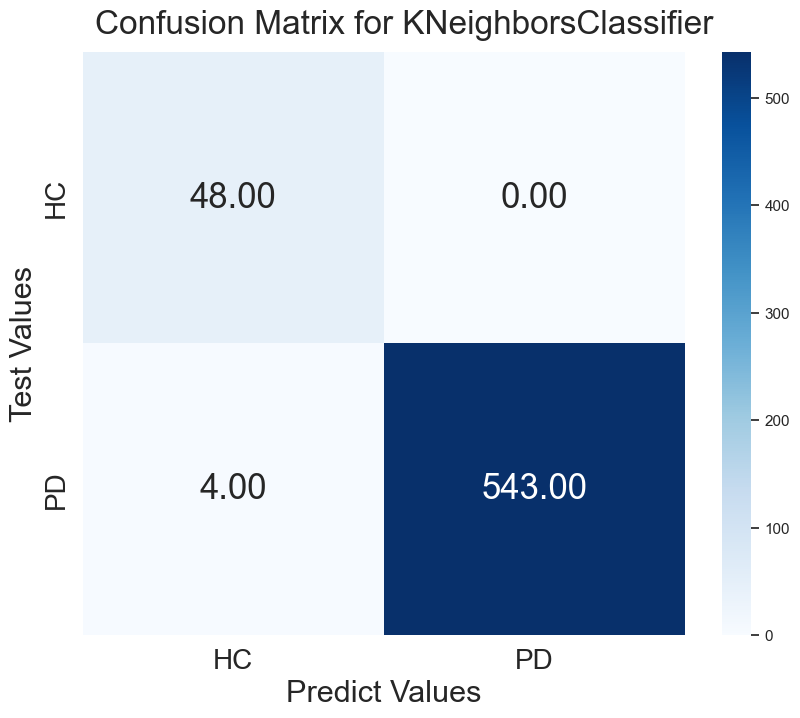

In [257]:
#Using the build_model function
knn_model, acc1, fpr1, tpr1, thresh1, auc1 = build_model('KNeighborsClassifier', X_train_resampled, 
                                                         y_train_resampled, X_test, y_test.values.ravel())

### 7.2. Decision Tree 

#### 7.2.1. Base DT-model result

In [50]:
#base model
dt_estimator = DecisionTreeClassifier(random_state=42)
dt_estimator.fit(X_train_resampled, y_train_resampled)
dt_pred = dt_estimator.predict(X_test)

print(f'Model accuracy test score:\n{dt_estimator.score(X_test, y_test)}\n')
print(classification_report(y_test, dt_pred))
print(confusion_matrix(y_test, dt_pred))

Model accuracy test score:
0.973109243697479

              precision    recall  f1-score   support

         0.0       0.81      0.88      0.84        48
         1.0       0.99      0.98      0.99       547

    accuracy                           0.97       595
   macro avg       0.90      0.93      0.91       595
weighted avg       0.97      0.97      0.97       595

[[ 42   6]
 [ 10 537]]


#### 7.2.2. Tuning DT

In [51]:
# Specifying the tunable parameters and the range of values
dt_parameters = {
    'max_depth': range (2, 10),
    'criterion':["gini", "entropy"],
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(2,5)
}

#Grid search
dt_GS = GridSearchCV(
    estimator= dt_estimator,
    param_grid= dt_parameters,
    scoring = ['accuracy', 'f1', 'precision'],
    refit = 'accuracy',
    n_jobs = -1, #speed
    cv = 5,
    verbose=True
)

# Training and results
dt_GS_results = dt_GS.fit(X_train_resampled, y_train_resampled)
dt_GS_results

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(2, 10),
                         'min_samples_leaf': range(2, 5),
                         'min_samples_split': range(2, 10)},
             refit='accuracy', scoring=['accuracy', 'f1', 'precision'],
             verbose=True)

In [52]:
#Get the best hyperparameter values we searched for
print(f'The best hyperparameter values for Decision Tree model:\n{dt_GS.best_params_} \n')

#Score according to the metric we passed in refit
print(f'Best mean cross-validation score: \n{dt_GS.best_score_}')

The best hyperparameter values for Decision Tree model:
{'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 2} 

Best mean cross-validation score: 
0.9709342042186002


#Full GridSearchCV-results
pd.DataFrame(dt_GS.cv_results_).sort_values("rank_test_accuracy")

#### 7.2.3. Best DT-model result

Model accuracy test score:  0.9815126050420168

 Classification Report: 
              precision    recall  f1-score   support

         0.0       0.89      0.88      0.88        48
         1.0       0.99      0.99      0.99       547

    accuracy                           0.98       595
   macro avg       0.94      0.93      0.94       595
weighted avg       0.98      0.98      0.98       595



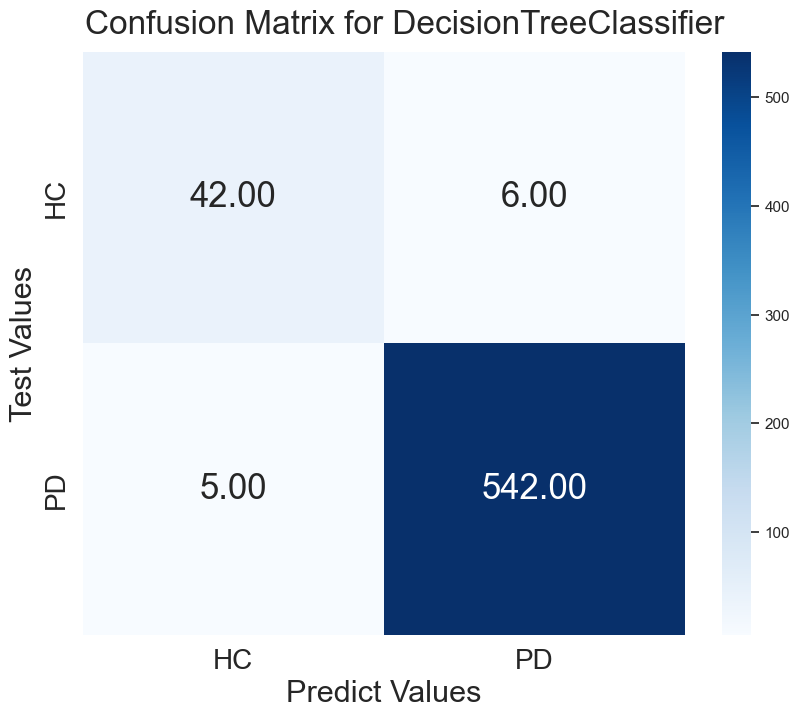

In [234]:
#Using the build_model function
dt_model, acc2, fpr2, tpr2, thresh2, auc2 = build_model('DecisionTreeClassifier', X_train_resampled, 
                                                        y_train_resampled, X_test, y_test.values.ravel())

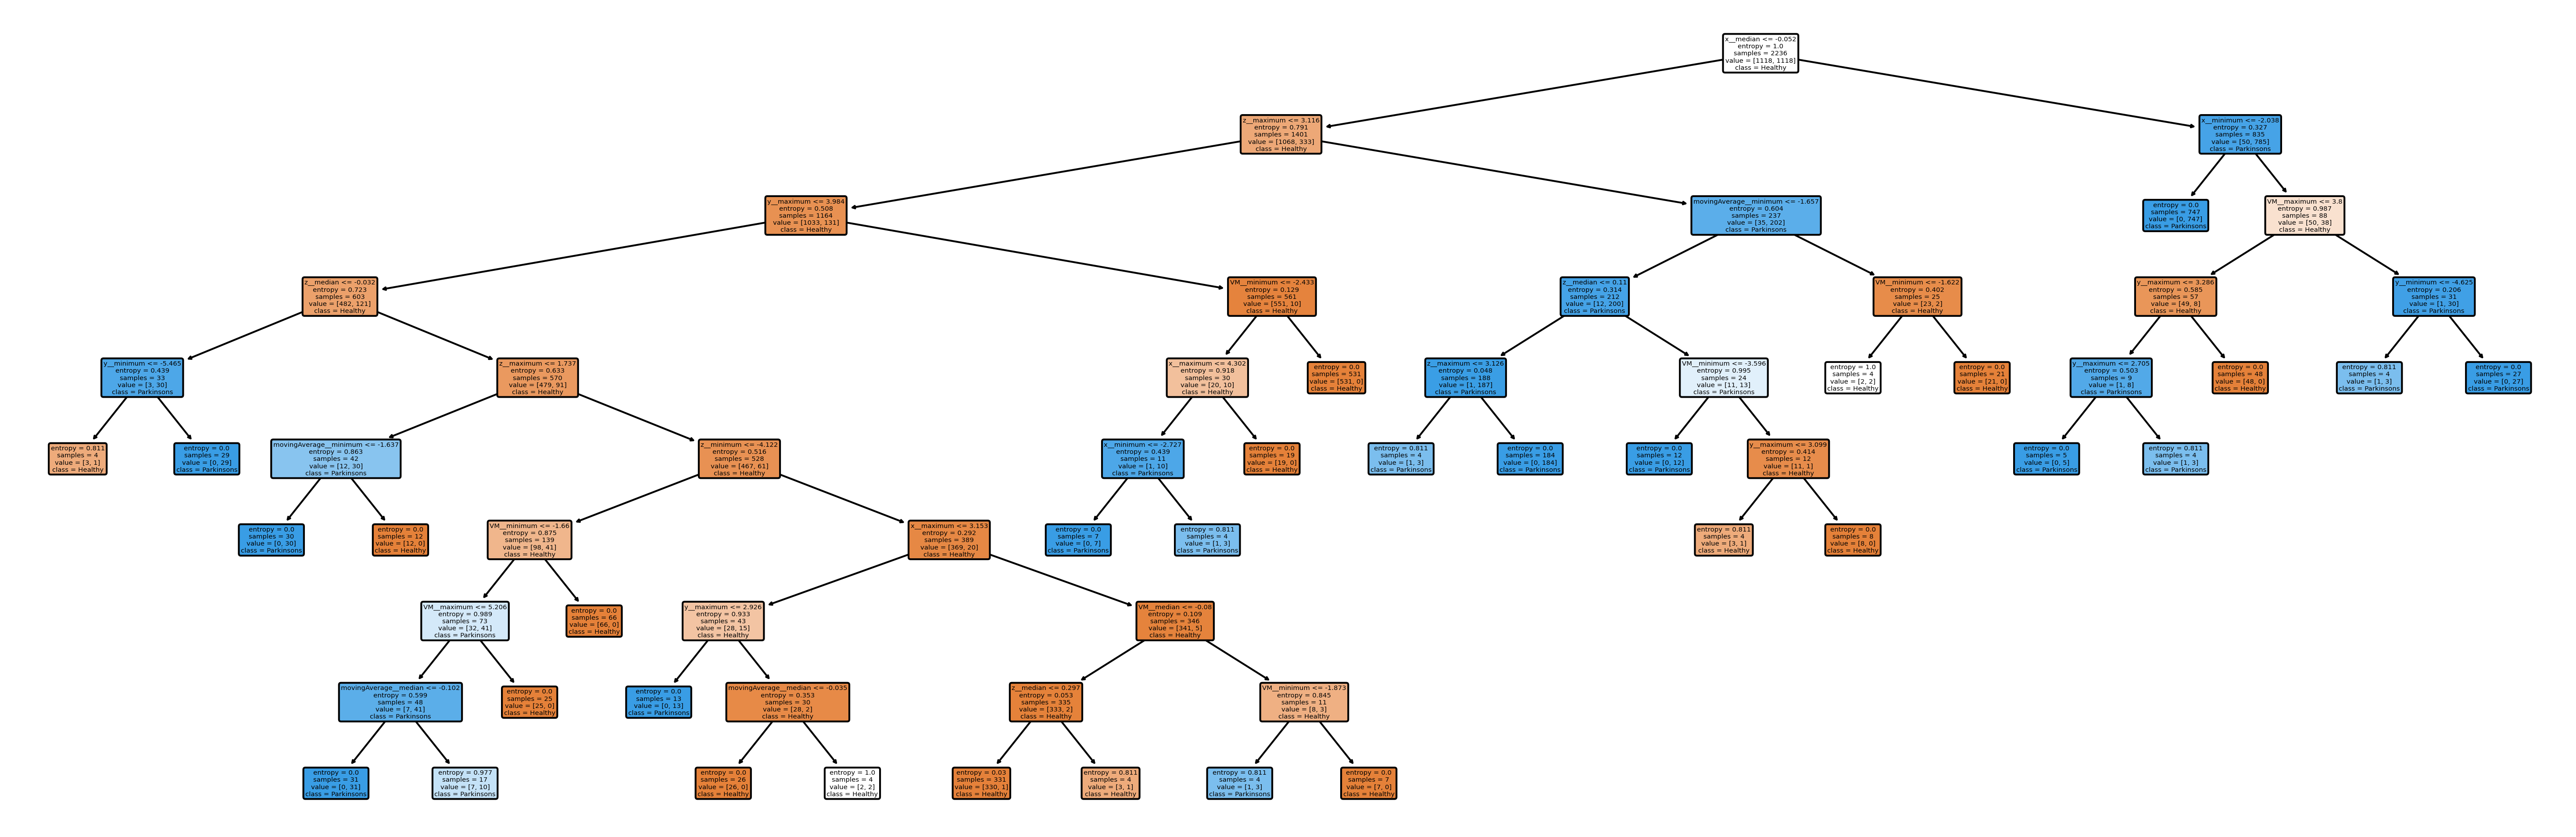

In [54]:
#Visulazing the tree

plt.figure(figsize=(25, 8), dpi=300)
tree_dot = plot_tree(dt_model,
                     filled=True, 
                     rounded = True, 
                     class_names = ["Healthy", "Parkinsons"], 
                     feature_names = X.columns)

### 7.3 Random Forest

#### 7.3.1. Base RF-model result

In [55]:
#base model
rf_estimator = RandomForestClassifier(random_state=42)
rf_estimator.fit(X_train_resampled, y_train_resampled)
rf_pred = rf_estimator.predict(X_test)

print(f'Model accuracy test score:\n{rf_estimator.score(X_test, y_test)}\n')
print(classification_report(y_test, rf_pred))
print(confusion_matrix(y_test, rf_pred))

Model accuracy test score:
0.984873949579832

              precision    recall  f1-score   support

         0.0       0.91      0.90      0.91        48
         1.0       0.99      0.99      0.99       547

    accuracy                           0.98       595
   macro avg       0.95      0.94      0.95       595
weighted avg       0.98      0.98      0.98       595

[[ 43   5]
 [  4 543]]


#### 7.3.2. Tuning RF

In [124]:
# Specifying the tunable parameters and the range of values
rf_parameters = {
    #'bootstrap': [True], <- default
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3], # how random a tree is, smaller reduces overfitting
    #'min_samples_leaf': [3, 4, 5],
    #'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000],
}

#Grid search
rf_GS = GridSearchCV(
    estimator= rf_estimator,
    param_grid= rf_parameters,
    scoring = ['accuracy', 'f1', 'precision'],
    refit = 'accuracy',
    n_jobs = -1,
    cv = 5,
    verbose=True
)

# Training and results
rf_GS_results = rf_GS.fit(X_train_resampled, y_train_resampled)
rf_GS_results

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=80, max_features=3,
                                              n_estimators=300,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3],
                         'n_estimators': [100, 200, 300, 1000]},
             refit='accuracy', scoring=['accuracy', 'f1', 'precision'],
             verbose=True)

In [125]:
#Get the best hyperparameter values we searched for
print(f'The best hyperparameter values for Decision Tree model:\n{rf_GS.best_params_} \n')

#Score according to the metric we passed in refit
print(f'Best mean cross-validation score: \n{rf_GS.best_score_}')

The best hyperparameter values for Decision Tree model:
{'bootstrap': True, 'max_depth': 80, 'max_features': 3, 'n_estimators': 300} 

Best mean cross-validation score: 
0.9964225790987535


#Full GridSearchCV-results
pd.DataFrame(rf_GS.cv_results_).sort_values("rank_test_accuracy")

#### 7.3.3. Best RF-model result

Model accuracy test score:  0.984873949579832

 Classification Report: 
              precision    recall  f1-score   support

         0.0       0.91      0.90      0.91        48
         1.0       0.99      0.99      0.99       547

    accuracy                           0.98       595
   macro avg       0.95      0.94      0.95       595
weighted avg       0.98      0.98      0.98       595



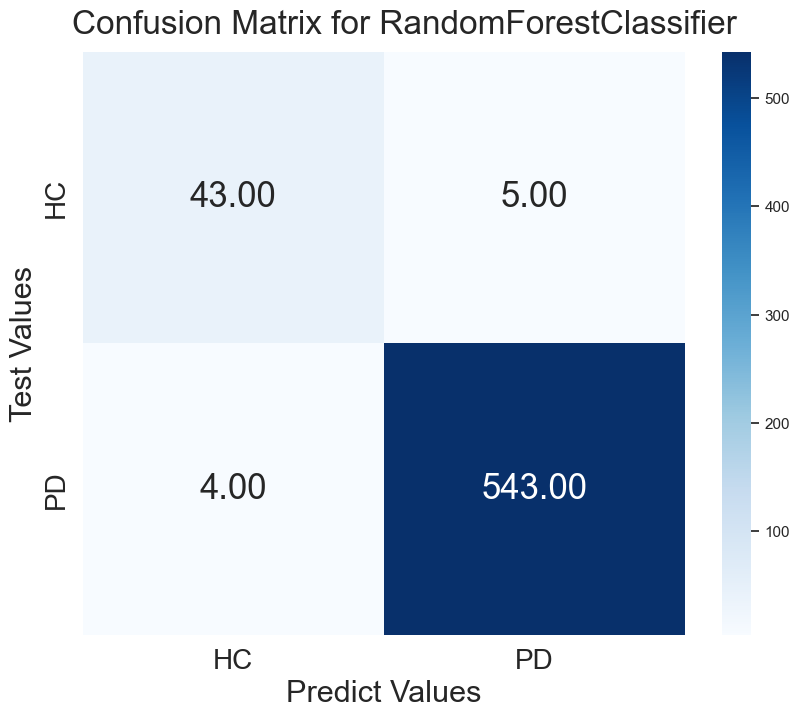

In [235]:
#Using the build_model function
rf_model, acc3, fpr3, tpr3, thresh3, auc3 = build_model('RandomForestClassifier', X_train_resampled, 
                                                        y_train_resampled, X_test, y_test.values.ravel())

### 7.4. SVM

#### 7.4.1. Base SVM-model result

In [60]:
#base model
svm_estimator = svm.SVC()
svm_estimator.fit(X_train_resampled, y_train_resampled)
svm_pred = svm_estimator.predict(X_test)

print(f'Model accuracy test score:\n{svm_estimator.score(X_test, y_test)}\n')
print(classification_report(y_test, svm_pred))
print(confusion_matrix(y_test, svm_pred))

Model accuracy test score:
0.8991596638655462

              precision    recall  f1-score   support

         0.0       0.44      0.96      0.61        48
         1.0       1.00      0.89      0.94       547

    accuracy                           0.90       595
   macro avg       0.72      0.93      0.77       595
weighted avg       0.95      0.90      0.92       595

[[ 46   2]
 [ 58 489]]


#### 7.4.2. Tuning SVM

In [61]:
# Specifying the tunable parameters and the range of values
svm_parameters = {
    'C': [0.1,1, 10, 100], 
    'gamma': [1,0.1,0.01,0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}


#Grid search
svm_GS = GridSearchCV(
    estimator=svm_estimator,
    param_grid=svm_parameters,
    scoring = ['accuracy', 'f1', 'precision'],
    refit = 'accuracy',
    n_jobs = -1,
    cv = 5,
    verbose=True
)

# Training and results
svm_GS_results = svm_GS.fit(X_train_resampled, y_train_resampled)
svm_GS_results

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             refit='accuracy', scoring=['accuracy', 'f1', 'precision'],
             verbose=True)

In [62]:
#Get the best hyperparameter values we searched for
print(f'The best hyperparameter values for XGBoost model:\n{svm_GS.best_params_} \n')

#Score according to the metric we passed in refit
print(f'Best mean cross-validation score: \n{svm_GS.best_score_}')

The best hyperparameter values for XGBoost model:
{'C': 10, 'gamma': 1, 'kernel': 'rbf'} 

Best mean cross-validation score: 
0.9973204298497922


#Full GridSearchCV-results
pd.DataFrame(svm_GS.cv_results_).sort_values("rank_test_accuracy")

#### 7.4.3. Best SVM-model result

Model accuracy test score:  0.9714285714285714

 Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      0.65      0.78        48
         1.0       0.97      1.00      0.98       547

    accuracy                           0.97       595
   macro avg       0.98      0.82      0.88       595
weighted avg       0.97      0.97      0.97       595



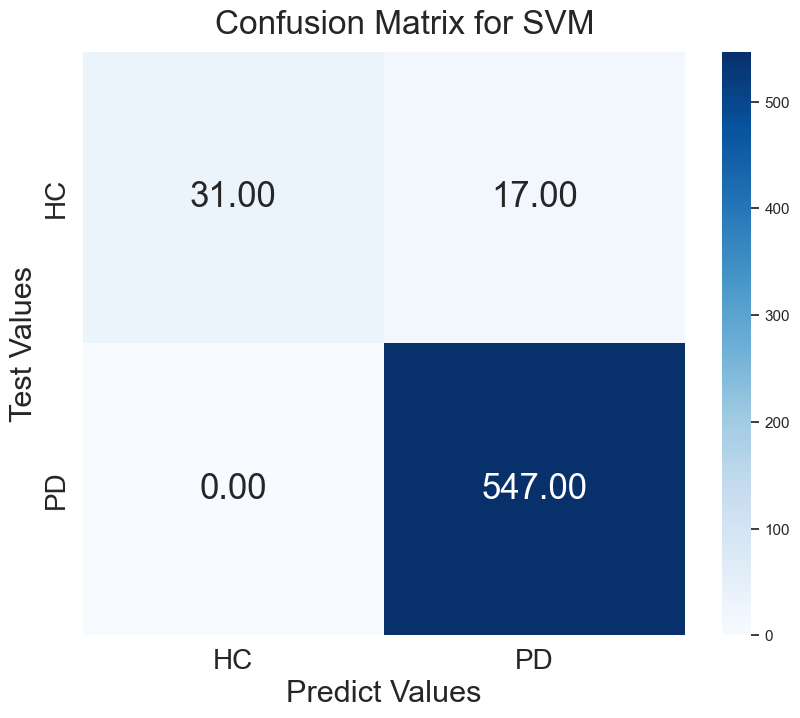

In [236]:
#Using the build_model function
svm_model, acc4, fpr4, tpr4, thresh4, auc4 = build_model('SVM', X_train_resampled, 
                                                         y_train_resampled, X_test, y_test.values.ravel())

### 7.5. XGBoost

#### 7.5.1. Base XGBoost-model result

In [64]:
#base model
xgb_estimator = XGBClassifier(
    objective= 'binary:logistic', #because we only train a classifier which handles 2 classes
    nthread=4,
    seed=42 #random number generator
)

xgb_estimator.fit(X_train_resampled, y_train_resampled)

xgb_pred = xgb_estimator.predict(X_test)

print(f'Model accuracy score:\n{xgb_estimator.score(X_test, y_test)}\n')
print(classification_report(y_test, xgb_pred))
print(confusion_matrix(y_test, xgb_pred))

Model accuracy score:
0.984873949579832

              precision    recall  f1-score   support

         0.0       0.91      0.90      0.91        48
         1.0       0.99      0.99      0.99       547

    accuracy                           0.98       595
   macro avg       0.95      0.94      0.95       595
weighted avg       0.98      0.98      0.98       595

[[ 43   5]
 [  4 543]]


#### 7.5.2. Tuning XGBoost

In [65]:
# Specifying the tunable parameters and the range of values
xgb_parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(1, 50, 40), #number of trees
     "gamma": [0.01, 0.1],
    'learning_rate': [0.1, 0.01, 0.05]
}

#Grid search
xgb_GS = GridSearchCV(
    estimator=xgb_estimator,
    param_grid=xgb_parameters,
    scoring = ['accuracy', 'f1', 'precision'],
    refit = 'accuracy',
    n_jobs = -1,
    cv = 5,
    verbose=True
)

# Training and results
xgboost_GS_results = xgb_GS.fit(X_train_resampled, y_train_resampled)
xgboost_GS_results

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=-1,
             param_grid={'gamma': [0.01, 0.1],
                         'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'n_estimators': range(1, 50, 40)},
             refit='accuracy', scoring=['accuracy', 'f1', 'precision'],
             verbose=True)

In [66]:
#Get the best hyperparameter values we searched for
print(f'The best hyperparameter values for XGBoost model:\n{xgb_GS.best_params_} \n')

#Score according to the metric we passed in refit
print(f'Best mean cross-validation score: \n{xgb_GS.best_score_}')

The best hyperparameter values for XGBoost model:
{'gamma': 0.01, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 41} 

Best mean cross-validation score: 
0.9888203100031958


#Full GridSearchCV-results
pd.DataFrame(xgb_GS.cv_results_).sort_values("rank_test_accuracy")

#### 7.5.3. Best XGBoost-model result

Model accuracy test score:  0.9815126050420168

 Classification Report: 
              precision    recall  f1-score   support

         0.0       0.86      0.92      0.89        48
         1.0       0.99      0.99      0.99       547

    accuracy                           0.98       595
   macro avg       0.93      0.95      0.94       595
weighted avg       0.98      0.98      0.98       595



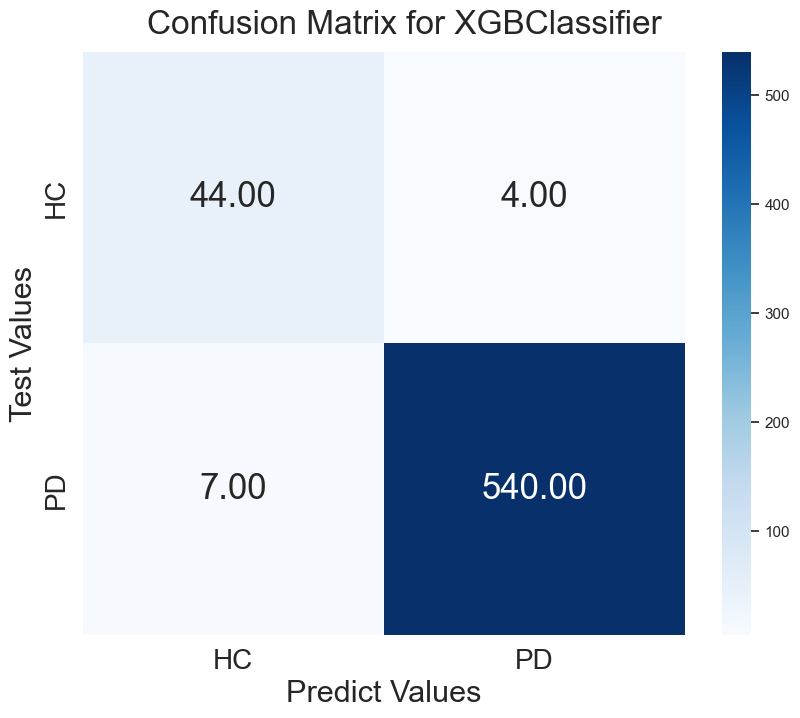

In [237]:
#Using the build_model function
xgb_model, acc5, fpr5, tpr5, thresh5, auc5 = build_model('XGBClassifier', X_train_resampled, 
                                                         y_train_resampled, X_test, y_test.values.ravel())

___________________________________________________________________________

# 8. Compare the ML-models 

### 8.1. ROC-Curve

In [68]:
# roc curve for tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

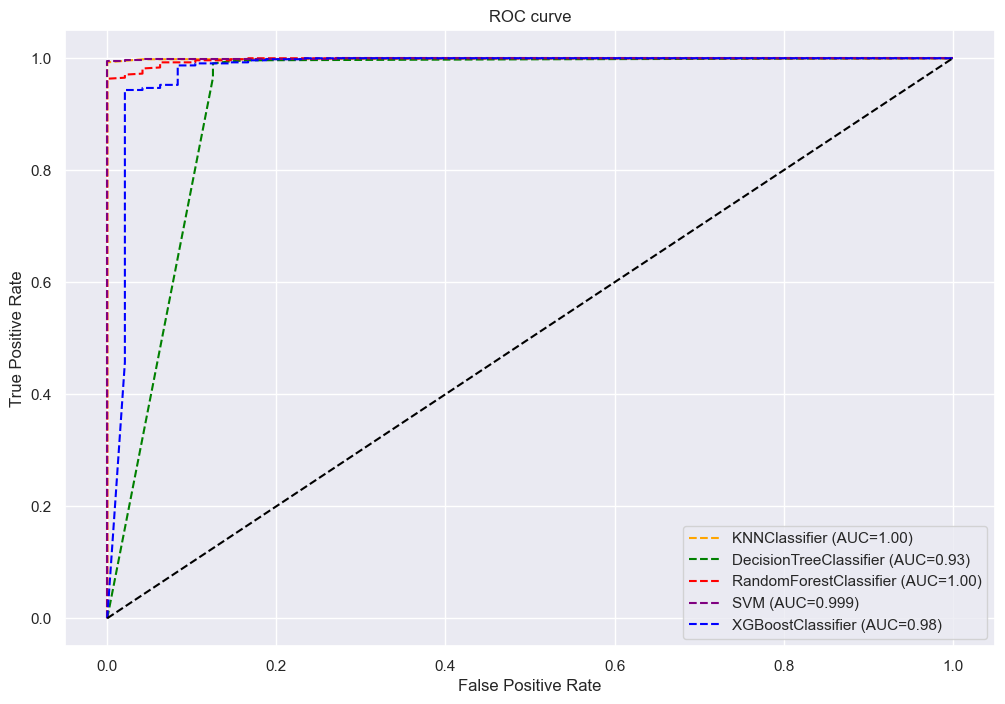

In [258]:
#plt.style.use('seaborn')
sns.set(style="darkgrid")
# Plot size settings
plt.rcParams['font.size'] = 12.0
plt.rcParams["figure.figsize"] = (12,8)

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='dashed',color='orange', label=f'KNNClassifier (AUC={auc1:.2f})')
plt.plot(fpr2, tpr2, linestyle='dashed',color='green', label=f'DecisionTreeClassifier (AUC={auc2:.2f})')
plt.plot(fpr3, tpr3, linestyle='dashed',color='red', label=f'RandomForestClassifier (AUC={auc3:.2f})')
plt.plot(fpr4, tpr4, linestyle='dashed',color='purple', label=f'SVM (AUC={auc4:.3f})')
plt.plot(fpr5, tpr5, linestyle='dashed',color='blue', label= f'XGBoostClassifier (AUC={auc5:.2f})')
plt.plot(p_fpr, p_tpr, linestyle='dashed', color='black')

# title
plt.title('ROC curve')

# x label
plt.xlabel('False Positive Rate')

# y label
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

### 8.2. Test accuarcy score 

In [72]:
#Comparisopn table
results=pd.DataFrame({'Model':['KNeighbors','DecisionTree', 'RandomForest', 'SVM','XGBoost'],
                    'Accuracy Score':[acc1, acc2, acc3, acc4, acc5],
                     'ROC Score':[auc1, auc2, auc3, auc4, auc5]})

result_df=results.sort_values(by='Accuracy Score', ascending=False)
result_df=result_df.set_index('Model')
result_df

,Accuracy Score,ROC Score
Model,,
KNeighbors,0.994958,0.998991
RandomForest,0.984874,0.997810
DecisionTree,0.981513,0.933672
XGBoost,0.981513,0.979700
SVM,0.971429,0.999391


___________________________________________________________________________

# 9. Voting Classifier

Accuracy of the Voting Classifier: 99.16%
AUC score of the Voting Classifier: 99.94%
              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95        48
         1.0       0.99      1.00      1.00       547

    accuracy                           0.99       595
   macro avg       0.99      0.96      0.97       595
weighted avg       0.99      0.99      0.99       595



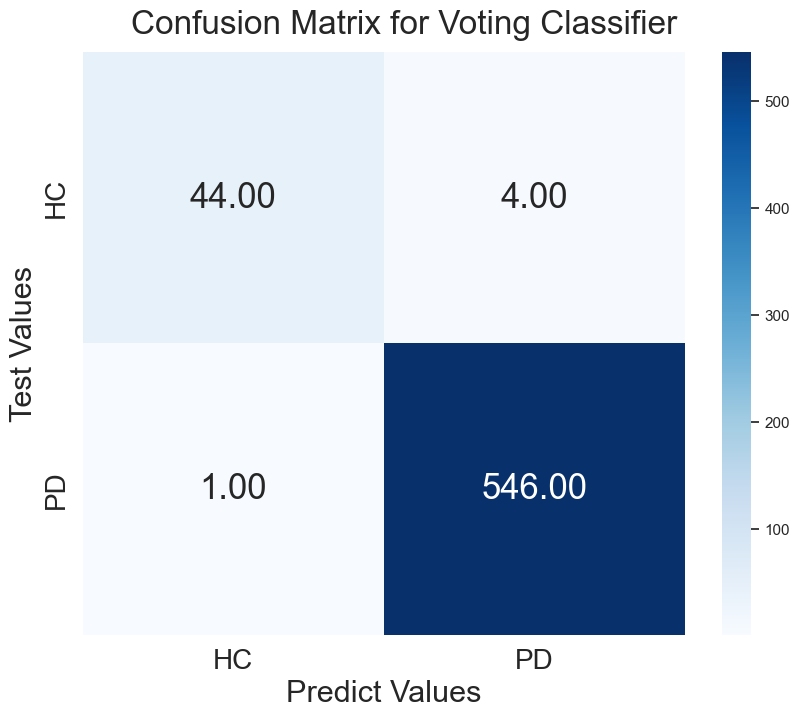

In [261]:
# Create a voting classifier
voting_clf = VotingClassifier(estimators=[('knn', knn_model), 
                                          ('dt', dt_model), 
                                          ('rf', rf_model), 
                                          ('svm', svm_model), 
                                          ('xgb', xgb_model)], 
                                          voting='soft')
# Fit the voting classifier on the training data
voting_clf.fit(X_train_resampled, y_train_resampled)

# Evaluate the voting classifier on the testing data
y_pred = voting_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy of the Voting Classifier: {:.2f}%".format(acc * 100))
auc_v = metrics.roc_auc_score(y_test, voting_clf.predict_proba(X_test)[:,1])
print("AUC score of the Voting Classifier: {:.2f}%".format(auc_v * 100))

print(classification_report(y_test, y_pred))

# create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# plot confusion matrix as heatmap
plt.rcParams["figure.figsize"] = (9,8)
plt.rcParams['font.size'] = 25.0 

class_labels = ["HC", "PD"]
sns.heatmap(cm, annot=True, fmt='.2f', cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.suptitle('Confusion Matrix for Voting Classifier', x=0.48, y=0.92, ha='center', fontsize=24)
plt.xlabel('Predict Values', fontsize =22)
plt.ylabel('Test Values', fontsize =22)
plt.tight_layout()
plt.show() 

In [131]:
#Calculating AUC
from sklearn import metrics

metrics.roc_auc_score(y_test, voting_clf.predict_proba(X_test)[:,1])


0.9992382693479586

__________________________________________________________________________________________________________________________

# 10: Gender

In [74]:
# Plot size settings
plt.rcParams["figure.figsize"] = (6,10)
font = {'weight' : 'normal',
        'size'   : 12}

### 10.1. Original ("features" dataframe) Distribution of the genders

In [75]:
gender = features['gender__minimum']
gender_count = features['gender__minimum'].value_counts() 
gender_count

0.0    1250
1.0     551
Name: gender__minimum, dtype: int64

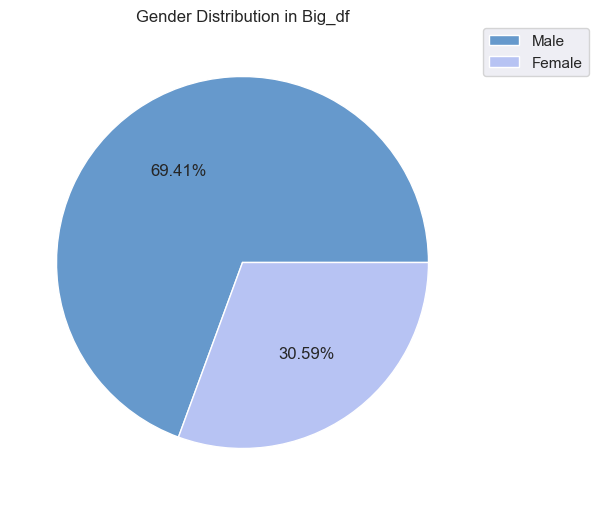

In [76]:
gender_labels = ["Male", "Female"] #1:female, 0:male
colors = ['#6699CC','#B7C3F3']
ax = gender_count.plot.pie(title = "Gender Distribution in Big_df", 
                           autopct='%1.2f%%', 
                           labels = gender_labels, 
                           legend = True, 
                           ylabel='', 
                           labeldistance=None,
                           colors = colors)
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

### 10.2. Gender Dataframes

#### 10.2.1. Only Males

In [77]:
male_df = features[features["gender__minimum"]==0]
#male_df

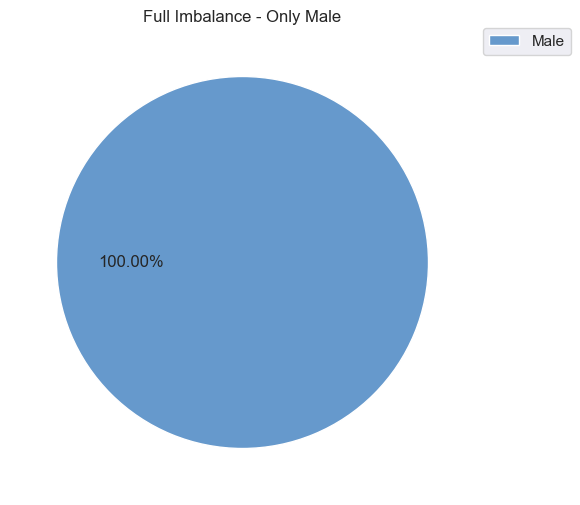

In [78]:
male_df_count = male_df['gender__minimum'].value_counts() 

colors = ['#6699CC']
male_labels = ["Male"]
ax = male_df_count.plot.pie(title = "Full Imbalance - Only Male", 
                            autopct='%1.2f%%', 
                            labels = male_labels, 
                            legend = True, ylabel='', 
                            labeldistance=None,
                            colors = colors)
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

#### 10.2.2. Only Females

In [79]:
list(selected_features)

['x__median',
 'x__maximum',
 'x__minimum',
 'movingAverage__minimum',
 'VM__median',
 'y__maximum',
 'movingAverage__median',
 'VM__minimum',
 'z__maximum',
 'z__median',
 'VM__maximum',
 'y__minimum',
 'z__minimum']

In [80]:
female_df = features[features["gender__minimum"]==1]
#female_df

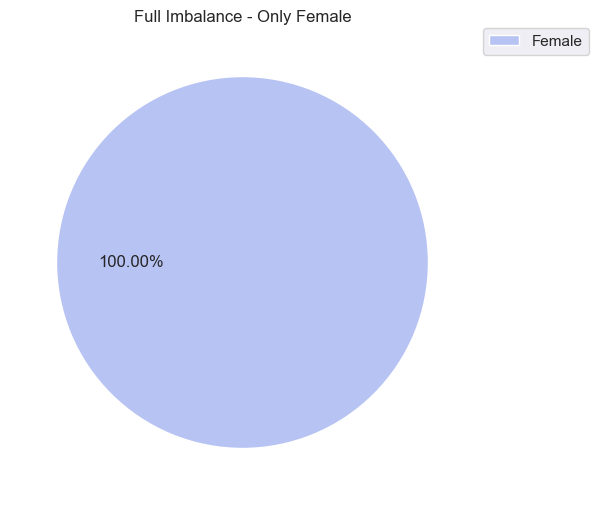

In [81]:
female_df_count = female_df['gender__minimum'].value_counts() 

colors = ['#B7C3F3']
female_labels = ["Female"]
ax = female_df_count.plot.pie(title = "Full Imbalance - Only Female", 
                              autopct='%1.2f%%', 
                              labels = female_labels, 
                              legend = True, ylabel='', 
                              labeldistance=None, 
                              colors = colors)
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

### 10.3. Splitting into features (X) and target variable (y)

In [82]:
# Female (100%)
# X_female = female_df[['x__median',
#               'x__maximum',
#               'x__minimum',
#               'y__median',
#               'y__maximum',
#               'y__minimum',
#               'z__median',
#               'z__maximum',
#               'z__minimum',
#               'VM__median',
#               'VM__maximum',
#               'VM__minimum',
#               'movingAverage__median',
#               'movingAverage__maximum',
#               'movingAverage__minimum']]

X_female = female_df[list(selected_features)]
y_female = female_df['label__mean']

# Male (100%)
# X_male = male_df[['x__median',
#               'x__maximum',
#               'x__minimum',
#               'y__median',
#               'y__maximum',
#               'y__minimum',
#               'z__median',
#               'z__maximum',
#               'z__minimum',
#               'VM__median',
#               'VM__maximum',
#               'VM__minimum',
#               'movingAverage__median',
#               'movingAverage__maximum',
#               'movingAverage__minimum']]
X_male = male_df[list(selected_features)]

y_male = male_df['label__mean']

### 10.4. Training on 80% female and test on both 20% female and 100% male

#### 10.4.1. Splitting female data into 80% training and 20% test

In [83]:
X_female80_train, X_female20_test, y_female80_train, y_female20_test = train_test_split(X_female, y_female, 
                                                                                  test_size=0.20, random_state=42)

#### 10.4.2. Reample class distribution

#Plot the distribution of patients with and without parkinsons in female df
ax = y_female80_train.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Orignal female class distribution")
Counter(y_female)

In [84]:
#Resample (mix) the data using SMOTE and RandomUnderSampler
smote = SMOTE(random_state=42)
rus = RandomUnderSampler(random_state=42)
X_train_female80_resamp, y_train_female80_resamp = smote.fit_resample(X_female80_train, y_female80_train)
X_train_female80_resamp, y_train_female80_resamp = rus.fit_resample(X_train_female80_resamp, y_train_female80_resamp)

#Print the shape of the original and resampled data
print(f"Original dataset shape: {X_female.shape}, {y_female.shape}")
print(f"Resampled dataset shape: {X_train_female80_resamp.shape}, {y_train_female80_resamp.shape}")

Original dataset shape: (551, 13), (551,)
Resampled dataset shape: (734, 13), (734,)


#Plot the distribution of patients with and without parkinsons
ax = y_train_female80_resamp.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Resample female class distribution")
Counter(y_train_female80_resamp) 

#### 10.4.3. ML-Models

##### 10.4.3.1. Voting Classifier

Accuracy of voting classifier: 98.20%
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94        18
         1.0       0.99      0.99      0.99        93

    accuracy                           0.98       111
   macro avg       0.97      0.97      0.97       111
weighted avg       0.98      0.98      0.98       111



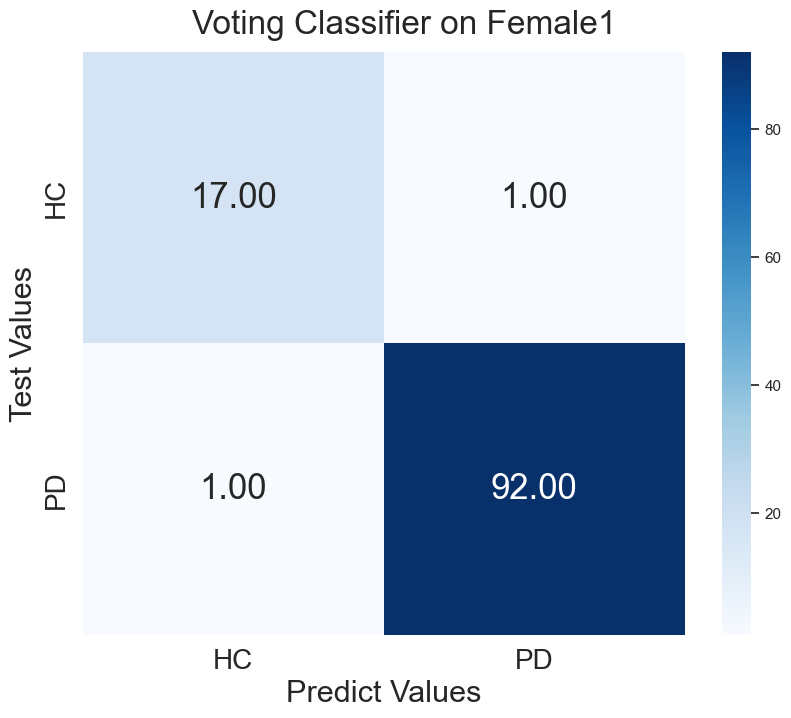

In [246]:
# Test on 20% female

# Fit the voting classifier on the training data
voting_clf.fit(X_train_female80_resamp, y_train_female80_resamp)

# Evaluate the voting classifier on the testing data
y_pred_female20 = voting_clf.predict(X_female20_test)
acc = accuracy_score(y_female20_test, y_pred_female20)
print("Accuracy of voting classifier: {:.2f}%".format(acc * 100))
print(classification_report(y_female20_test, y_pred_female20))

# create confusion matrix
cm_female = confusion_matrix(y_female20_test, y_pred_female20)

# plot confusion matrix as heatmap
class_labels = ["HC", "PD"]
sns.heatmap(cm_female, annot=True, fmt='.2f', cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

# set plot labels
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.suptitle('Voting Classifier on Female1', x=0.48, y=0.92, ha='center', fontsize=24)
plt.xlabel('Predict Values', fontsize =22)
plt.ylabel('Test Values', fontsize =22)
plt.tight_layout()
plt.show()

Accuracy of voting classifier: 82.80%
              precision    recall  f1-score   support

         0.0       0.17      0.98      0.29        45
         1.0       1.00      0.82      0.90      1205

    accuracy                           0.83      1250
   macro avg       0.58      0.90      0.60      1250
weighted avg       0.97      0.83      0.88      1250



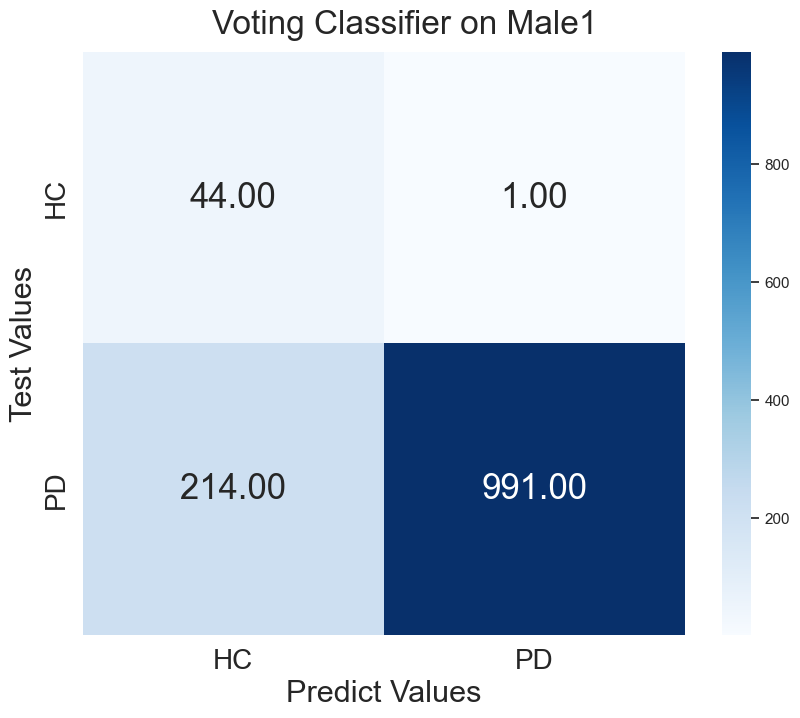

In [245]:
# Test on 100% male

# Fit the voting classifier on the training data
voting_clf.fit(X_train_female80_resamp, y_train_female80_resamp)

# Evaluate the voting classifier on the testing data
y_pred_male100 = voting_clf.predict(X_male)
acc = accuracy_score(y_male, y_pred_male100)
print("Accuracy of voting classifier: {:.2f}%".format(acc * 100))
print(classification_report(y_male, y_pred_male100))

# create confusion matrix
cm_male = confusion_matrix(y_male, y_pred_male100)

# plot confusion matrix as heatmap
class_labels = ["HC", "PD"]
sns.heatmap(cm_male, annot=True, fmt='.2f', cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

# set plot labels
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.suptitle('Voting Classifier on Male1', x=0.48, y=0.92, ha='center', fontsize=24)
plt.xlabel('Predict Values', fontsize =22)
plt.ylabel('Test Values', fontsize =22)
plt.tight_layout()
plt.show()

##### 10.4.3.2. KNeighborsClassifier

Model accuracy test score:  0.990990990990991

 Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97        18
         1.0       0.99      1.00      0.99        93

    accuracy                           0.99       111
   macro avg       0.99      0.97      0.98       111
weighted avg       0.99      0.99      0.99       111



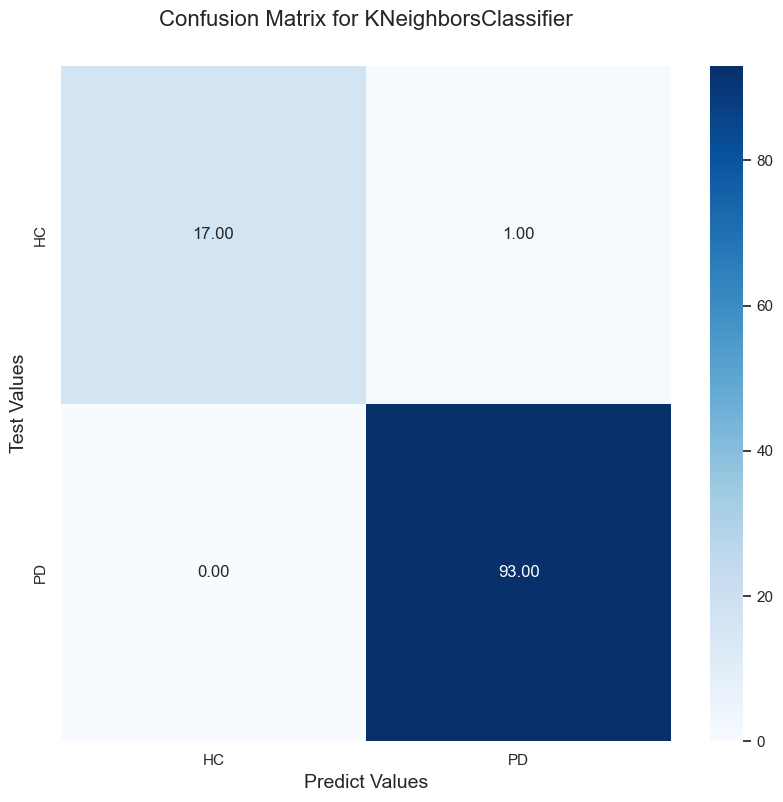

(KNeighborsClassifier(leaf_size=1, metric='manhattan', n_neighbors=3,
                      weights='distance'),
 0.990990990990991,
 array([0.        , 0.        , 0.05555556, 1.        ]),
 array([0., 1., 1., 1.]),
 array([2.        , 1.        , 0.68605427, 0.        ]),
 1.0)

In [148]:
# Test on 20% female
build_model('KNeighborsClassifier', 
            X_train_female80_resamp, 
            y_train_female80_resamp, 
            X_female20_test, 
            y_female20_test.values.ravel())

Model accuracy test score:  0.724

 Classification Report: 
              precision    recall  f1-score   support

         0.0       0.12      1.00      0.21        45
         1.0       1.00      0.71      0.83      1205

    accuracy                           0.72      1250
   macro avg       0.56      0.86      0.52      1250
weighted avg       0.97      0.72      0.81      1250



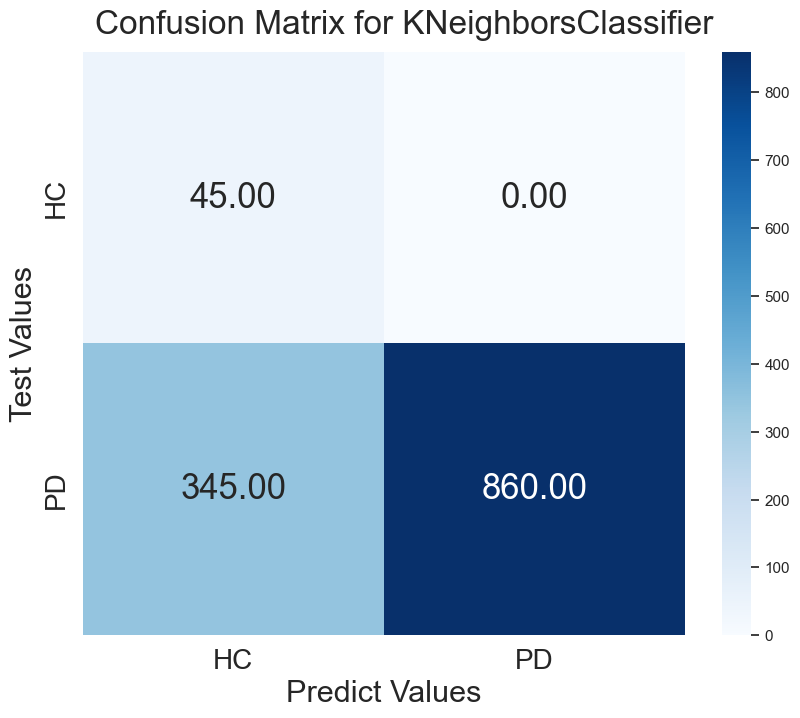

(KNeighborsClassifier(leaf_size=1, metric='manhattan', n_neighbors=3,
                      weights='distance'),
 0.724,
 array([0., 0., 0., 1.]),
 array([0.        , 0.66473029, 0.79170124, 1.        ]),
 array([2.        , 1.        , 0.25693109, 0.        ]),
 0.8958506224066389)

In [250]:
# Test on 100% male
build_model('KNeighborsClassifier', 
            X_train_female80_resamp, 
            y_train_female80_resamp, 
            X_male, 
            y_male.values.ravel())

### 10.5. Training on 80% male and test on both 20% male and 100% female

#### 10.5.1. Splitting male data into training and 20% test

In [89]:
X_male80_train, X_male20_test, y_male80_train, y_male20_test = train_test_split(X_male, y_male, 
                                                                            test_size=0.20, random_state=42)

#### 10.5.2. Reample class distribution

#Plot the distribution of patients with and without parkinsons in male df 
ax = y_male.value_counts().plot.pie(autopct='%.2f') 
_ = ax.set_title("Orignal male class distribution") 
Counter(y_male)

In [90]:
#Resample (mix) the data using SMOTE and RandomUnderSampler
smote = SMOTE(random_state=42)
rus = RandomUnderSampler(random_state=42)
X_train_male80_resamp, y_train_male80_resamp = smote.fit_resample(X_male80_train, y_male80_train)
X_train_male80_resamp, y_train_male80_resamp = rus.fit_resample(X_train_male80_resamp, y_train_male80_resamp)

#Print the shape of the original and resampled data
print(f"Original dataset shape: {X_male.shape}, {y_male.shape}")
print(f"Resampled dataset shape: {X_train_male80_resamp.shape}, {y_train_male80_resamp.shape}")

Original dataset shape: (1250, 13), (1250,)
Resampled dataset shape: (1922, 13), (1922,)


#Plot the distribution of patients with and without parkinsons
ax = y_train_male80_resamp.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Resample male class distribution")
Counter(y_train_male80_resamp) 

### 10.5.3. ML-Models

##### 10.5.3.1. Voting Classifier

Accuracy of voting classifier: 98.80%
              precision    recall  f1-score   support

         0.0       1.00      0.50      0.67         6
         1.0       0.99      1.00      0.99       244

    accuracy                           0.99       250
   macro avg       0.99      0.75      0.83       250
weighted avg       0.99      0.99      0.99       250



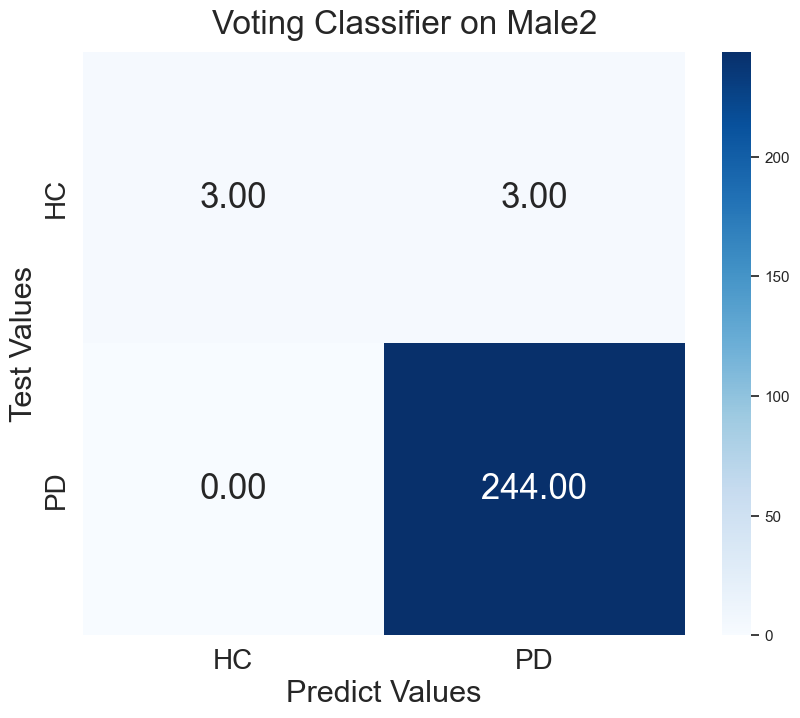

In [248]:
# Test on 20% male

# Fit the voting classifier on the training data
voting_clf.fit(X_train_male80_resamp, y_train_male80_resamp)

# Evaluate the voting classifier on the testing data
y_pred_male20 = voting_clf.predict(X_male20_test)
acc = accuracy_score(y_male20_test, y_pred_male20)
print("Accuracy of voting classifier: {:.2f}%".format(acc * 100))
print(classification_report(y_male20_test, y_pred_male20))

# create confusion matrix
cm_male = confusion_matrix(y_male20_test, y_pred_male20)

# plot confusion matrix as heatmap
class_labels = ["HC", "PD"]
sns.heatmap(cm_male, annot=True, fmt='.2f', cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)


# set plot labels
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.suptitle('Voting Classifier on Male2', x=0.48, y=0.92, ha='center', fontsize=24)
plt.xlabel('Predict Values', fontsize =22)
plt.ylabel('Test Values', fontsize =22)
plt.tight_layout()
plt.show()

Accuracy of voting classifier: 92.20%
              precision    recall  f1-score   support

         0.0       1.00      0.53      0.69        91
         1.0       0.91      1.00      0.96       460

    accuracy                           0.92       551
   macro avg       0.96      0.76      0.82       551
weighted avg       0.93      0.92      0.91       551



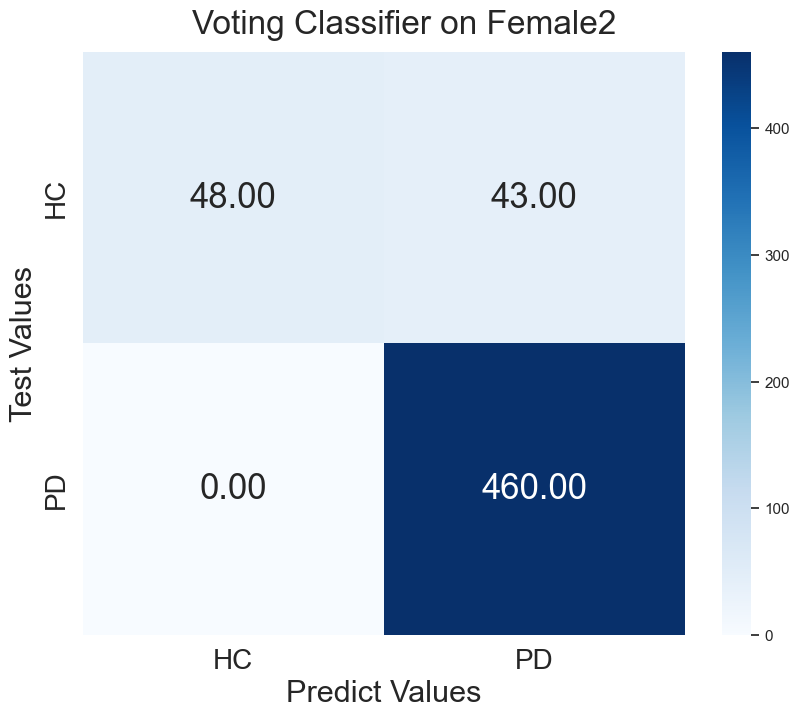

In [249]:
# Test on 100% female

# Fit the voting classifier on the training data
voting_clf.fit(X_train_male80_resamp, y_train_male80_resamp)

# Evaluate the voting classifier on the testing data
y_pred_female100 = voting_clf.predict(X_female)
acc = accuracy_score(y_female, y_pred_female100)
print("Accuracy of voting classifier: {:.2f}%".format(acc * 100))
print(classification_report(y_female, y_pred_female100))

# create confusion matrix
cm_female = confusion_matrix(y_female, y_pred_female100)

# plot confusion matrix as heatmap
class_labels = ["HC", "PD"]
sns.heatmap(cm_female, annot=True, fmt='.2f', cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

# set plot labels
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.suptitle('Voting Classifier on Female2', x=0.48, y=0.92, ha='center', fontsize=24)
plt.xlabel('Predict Values', fontsize =22)
plt.ylabel('Test Values', fontsize =22)
plt.tight_layout()
plt.show()

##### 10.5.3.2. KNeighborsClassifier

Model accuracy test score:  0.984

 Classification Report: 
              precision    recall  f1-score   support

         0.0       0.75      0.50      0.60         6
         1.0       0.99      1.00      0.99       244

    accuracy                           0.98       250
   macro avg       0.87      0.75      0.80       250
weighted avg       0.98      0.98      0.98       250



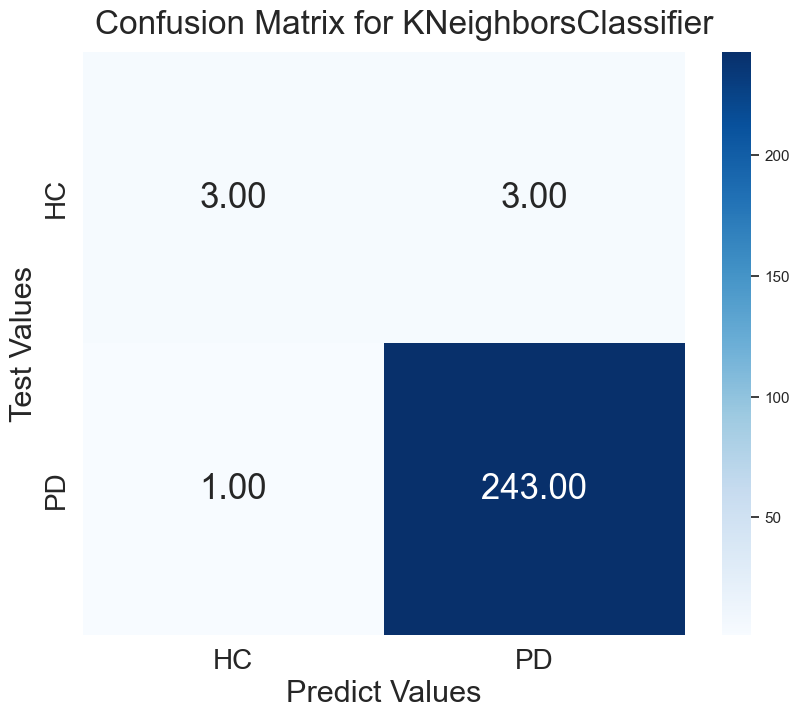

(KNeighborsClassifier(leaf_size=1, metric='manhattan', n_neighbors=3,
                      weights='distance'),
 0.984,
 array([0. , 0.5, 0.5, 1. ]),
 array([0.        , 0.99180328, 1.        , 1.        ]),
 array([2.        , 1.        , 0.33498995, 0.        ]),
 0.7479508196721312)

In [251]:
#Test on 20% male
build_model('KNeighborsClassifier', 
            X_train_male80_resamp,
            y_train_male80_resamp, 
            X_male20_test, 
            y_male20_test.values.ravel())

Model accuracy test score:  0.9382940108892922

 Classification Report: 
              precision    recall  f1-score   support

         0.0       0.89      0.71      0.79        91
         1.0       0.95      0.98      0.96       460

    accuracy                           0.94       551
   macro avg       0.92      0.85      0.88       551
weighted avg       0.94      0.94      0.94       551



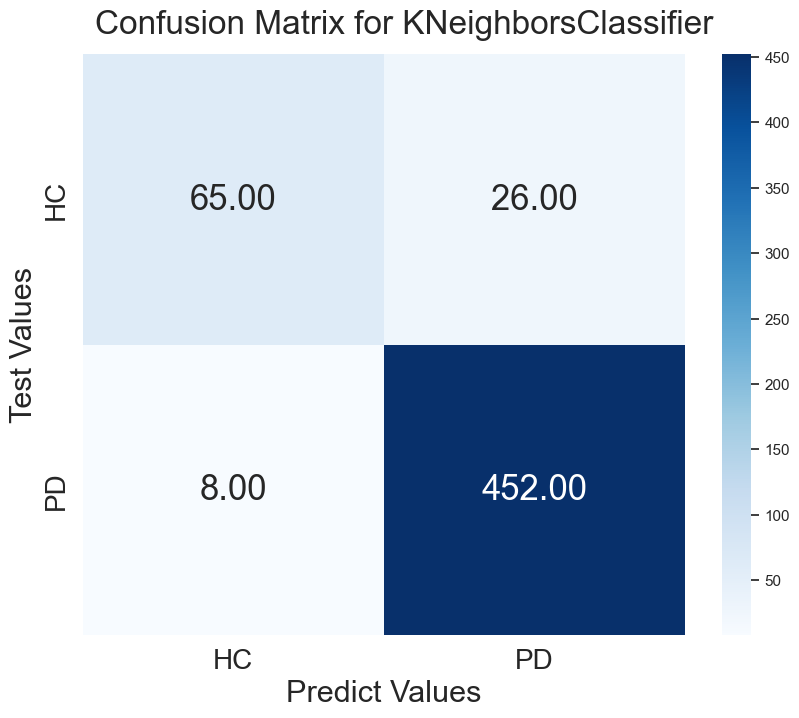

(KNeighborsClassifier(leaf_size=1, metric='manhattan', n_neighbors=3,
                      weights='distance'),
 0.9382940108892922,
 array([0.        , 0.24175824, 0.30769231, 0.30769231, 0.32967033,
        0.32967033, 0.34065934, 0.34065934, 1.        ]),
 array([0.        , 0.9826087 , 0.9826087 , 0.98478261, 0.98478261,
        0.98695652, 0.98695652, 0.99130435, 1.        ]),
 array([2.        , 1.        , 0.3835299 , 0.35242255, 0.3453878 ,
        0.34344878, 0.33599888, 0.33214293, 0.        ]),
 0.8725274725274725)

In [252]:
# Test on 100% female
build_model('KNeighborsClassifier', 
            X_train_male80_resamp,
            y_train_male80_resamp, 
            X_female, 
            y_female.values.ravel())